In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import seaborn as sns
from IPython.display import display, Markdown
import itertools
import joblib
import csv

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.cluster import KMeans, DBSCAN,\
    AgglomerativeClustering, linkage_tree
from sklearn.metrics import calinski_harabasz_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram
from sklearn.base import BaseEstimator, TransformerMixin

from Functions import get_n_rowcol

from sklearn import set_config
set_config(display="diagram")

In [2]:
%matplotlib inline

In [3]:
data_cust_raw = pd.read_parquet('data_wrangled/data_cust.parquet')
data_cust_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98666 entries, 0 to 98665
Columns: 116 entries, customer_id to order_distance
dtypes: datetime64[ns](1), float64(104), int64(6), object(5)
memory usage: 87.3+ MB


# 3. Exploration de la base clients

## 3.1. Transformations finales

### 3.5.1. Regroupement des commandes par client

Comme nous avons pu le voir, chaque client peut avoir effectué plusieurs commandes. A ce stade, chaque ligne de notre base correspond en réalité à une commande unique. Il nous faut donc les regrouper par client.

Pour ce faire, nous mettons en place différentes approches pour agréger les données par commande:
- Somme pour : les montants payés, le nombre de produits par commande et par type, le nombre de commandes par événement
- Décompte des numéros de commandes uniques
- Date de commande la plus récente
- Omission de l'année de la commande
- Moyenne pour les autres

In [4]:
cols = data_cust_raw.columns

In [5]:
# Id unique
id_cols = ['customer_unique_id']

In [6]:
# Colonnes dont la somme sera faite
day_cols = cols[cols.str.startswith('d_')].tolist()
prod_cols = cols[cols.str.startswith('prod_cat_')].tolist()
nb_prod_cols = ['order_item_id']
price_cols = ['price', 'freight_value']
payment_cols = ['boleto', 'credit_card',
                'debit_card', 'not_defined', 'voucher']
review_cols = ['review_score_max', 'review_score_mean', 'review_score_min']
sum_cols = day_cols + prod_cols + nb_prod_cols +\
    price_cols + payment_cols + review_cols

In [7]:
# Colonnes dont le comptage sera fait
count_cols = ['order_id', 'review_id_count']

In [8]:
# Colonnes dont le max sera pris
max_cols = ['order_purchase_timestamp']

In [9]:
# Colonnes exclues
excluded_cols = ['has_comment_max',
                 'order_purchase_year',
                 'customer_id',
                 'geolocation_lat_order',
                 'geolocation_lng_order']

In [10]:
# Colonnes dont la derniere valeur disponible sera consideree
last_cols = ['customer_zip_code_prefix',
             'customer_city',
             'customer_state',
             'geolocation_lat',
             'geolocation_lng']

In [11]:
# Colonnes dont la moyenne sera faite
mean_cols = np.setdiff1d(
    data_cust_raw.columns,
    id_cols + sum_cols + count_cols +
    max_cols + excluded_cols + last_cols).tolist()
mean_cols

['order_distance',
 'order_purchase_day',
 'order_purchase_hour',
 'order_purchase_month',
 'order_purchase_to_delivery',
 'payment_installments',
 'payment_sequential',
 'product_description_lenght',
 'product_height_cm',
 'product_length_cm',
 'product_name_lenght',
 'product_vol_cm3',
 'product_weight_g',
 'product_width_cm']

In [12]:
# Classement de la base client par ordre chronologique des commandes
data_cust_raw.sort_values(by='order_purchase_timestamp', inplace=True)

In [13]:
# Creation d'un dictionnaire des transformations a appliquer
agg_dict = {}

operations = ['sum', 'count', 'max', 'last', 'mean']
col_groups = [sum_cols, count_cols, max_cols, last_cols, mean_cols]

for col_table, operation in zip(col_groups, operations):
    for col in col_table:
        agg_dict[col] = operation

In [14]:
# Aggregation des lignes
data_cust = data_cust_raw.groupby(id_cols, as_index=False).agg(agg_dict)
data_cust.head()

,customer_unique_id,d_christmas,d_valentines,d_mothers,d_fathers,d_children,prod_cat_agro_industry_and_commerce,prod_cat_air_conditioning,prod_cat_art,prod_cat_arts_and_craftmanship,...,order_purchase_to_delivery,payment_installments,payment_sequential,product_description_lenght,product_height_cm,product_length_cm,product_name_lenght,product_vol_cm3,product_weight_g,product_width_cm
0,0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,141.90,0.00,0.0,0.0,0.0,0.0,...,10.0,8.0,1.0,236.0,7.0,34.0,60.0,7616.0,1500.0,32.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,27.19,0.00,0.0,0.0,0.0,0.0,...,7.0,1.0,1.0,635.0,11.0,26.0,56.0,5148.0,375.0,18.0
2,0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,27.0,8.0,1.0,177.0,50.0,25.0,49.0,43750.0,1500.0,35.0
3,0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,0.0,0.00,43.62,0.0,0.0,0.0,0.0,...,31.0,4.0,1.0,1741.0,5.0,19.0,43.0,1045.0,150.0,11.0
4,0004aac84e0df4da2b147fca70cf8255,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,20.0,6.0,1.0,794.0,3.0,16.0,58.0,528.0,6050.0,11.0


In [15]:
display(Markdown(f"Notre base de donnees contient desormais\
    {data_cust.shape[0]:,d} lignes et {data_cust.shape[1]:,d} colonnes."))

Notre base de donnees contient desormais    95,420 lignes et 112 colonnes.

### 3.5.2. Créations de ratios / fréquences

Parmi nos variables numériques, certaines ne nous intéressent qu'en relation avec d'autres de la même nature, et d'autres ne nous intéressent qu'au travers de leur valeur moyenne. Nous allons donc créer ou transformer les variables suivantes :
- Part du montant total de commande par catégorie de produits
- Part du montant total payé selon le mode de paiement
- Part des commandes passées dans les périodes de fêtes identifiées
- Note moyenne par client

In [16]:
# Colonnes pour lesquelles une frequence relative sera calculee
freq_var = [prod_cols, payment_cols]

# Calcul de la frequence relative
for cols in freq_var:
    data_raw = data_cust[cols].copy()
    data_cust.loc[:, cols] = \
        data_raw.div(data_raw.sum(axis=1), axis=0, fill_value=None)

In [17]:
# Calcul d'un ratio total pour les depenses liees aux fetes
data_cust[day_cols] = data_cust[day_cols].div(
    data_cust[['price', 'freight_value']].sum(axis=1),
    axis=0)

In [18]:
# Calcul de la moyenne des notes laissees par les clients
data_cust[review_cols] =\
    data_cust[review_cols].div(data_cust['review_id_count'], axis=0)
# Exclusion de la colonne du nombre de commentaires
data_cust.drop(columns=['review_id_count'], inplace=True)

### 3.5.3. Catégories spécifiques RFM

Notre objectif étant de réaliser un clustering d'une base clients, une approche habituelle et en général efficace est celle dite de RFM. Cet acronyme représente les dimensions utilisées :
- La récence (R) du dernier achat effectué
- La fréquence (F) d'achats par période donnée
- Le montant (M) total des achats sur cette période

Nous allons donc calculer ces variables pour notre base client.

In [19]:
date_min = data_cust['order_purchase_timestamp'].min()
date_max = data_cust['order_purchase_timestamp'].max()
time_diff = date_max-date_min
time_diff = round(time_diff.days/365)

In [20]:
# Recence : nombre de jours depuis la derniere commande
data_cust['rfm_R'] = date_max - data_cust['order_purchase_timestamp']
# Conversion en jours
data_cust['rfm_R'] = data_cust['rfm_R'].dt.days

Pour la fréquence et le montant, nous allons considérer des données annuelles, en divisant donc le total par la période totale couverte par notre base, soit 2 ans environ.

In [21]:
# Frequence
data_cust['rfm_F'] = data_cust['order_id'] / time_diff
# Montant
data_cust['rfm_M'] = data_cust['price'] / time_diff

### 3.5.4. Imputation des dernières valeurs manquantes

Nous étudions pour finir les variables contenant des valeurs manquantes.

In [22]:
na_val = data_cust.isna().sum()[data_cust.isna().sum() > 0]
na_val

review_score_max     699
review_score_mean    699
review_score_min     699
dtype: int64

Les valeurs manquantes correspondent à une absence de commentaire pour certains clients. Nous imputerons ces valeurs par la médiane observée sur notre échantillon, afin de minimiser l'impact de cette imputation si nous utilisons cette variable pour la catégorisation. Cette imputation se fera si nous décidons d'utiliser une de ces variables pour notre classification.

## 3.2. Analyse univariée

Nous pouvons désormais explorer la base clients au travers des différentes variables contenues.

### 3.2.1. Nombre de commandes par clients

Nous commençons par observer le nombre de commandes par clients.

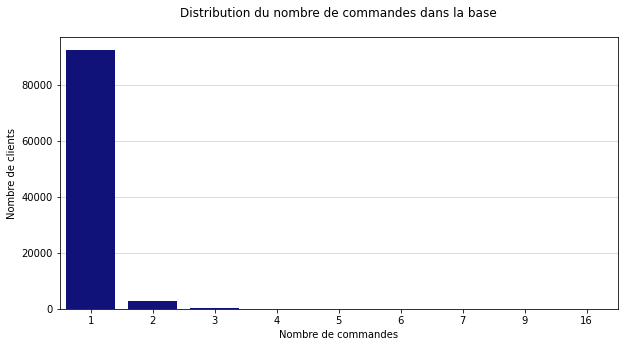

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.countplot(
    data=data_cust,
    x='order_id',
    color='darkblue'
)

ax.set_xlabel('Nombre de commandes')
ax.set_ylabel('Nombre de clients')
ax.set_title('Distribution du nombre de commandes dans la base', pad=20)

ax.grid(visible=True, axis='y', color='lightgrey')
ax.set_axisbelow(True)

plt.savefig('figures/nb_commandes.png', bbox_inches='tight')

plt.show()

In [24]:
pct_1_order = data_cust['order_id'].value_counts()[1] / data_cust.shape[0]
display(Markdown(
    f"Au sein de notre base de donnees, seuls {1-pct_1_order:.0%}\
    des clients ont effectue plus d'une seule commande sur la periode."))

Au sein de notre base de donnees, seuls 3%    des clients ont effectue plus d'une seule commande sur la periode.

Cette information est cruciale, car elle nous indique que nous ne pourrons vraisemblablement pas nous baser sur certaines variables nécessitant un nombre modéré de commandes par client pour apporter une information utile au travers d'un profil client, notamment : types de produits commandés, moyens de paiement utilisés.

Nous visualisons également la distribution de la variable F(réquence), correspondant au nombre annuel de commandes.

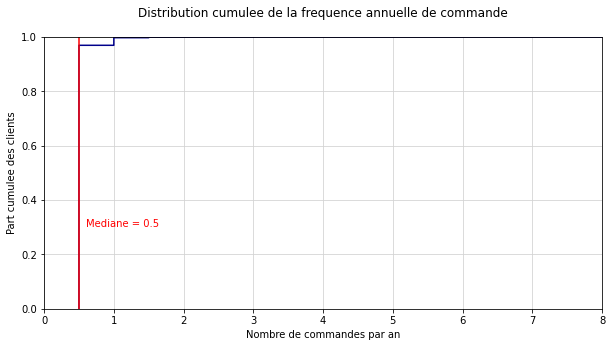

In [25]:
fig_data = data_cust['rfm_F']

fig, ax = plt.subplots(figsize=(10, 5))

sns.ecdfplot(
    x=fig_data,
    color='darkblue'
)

ax.set_xlabel('Nombre de commandes par an')
ax.set_ylabel('Part cumulee des clients')
ax.set_title('Distribution cumulee de la frequence annuelle de commande',
             pad=20)

median = fig_data.median()

ax.vlines(
    x=median,
    ymin=0,
    ymax=1,
    color='red'
)

ax.annotate(
    text=f"Mediane = {median:.1f}",
    xy=(median+0.1, 0.3),
    color='red'
)

ax.set_xlim(
    left=0,
    right=fig_data.max()
)

ax.grid(visible=True, color='lightgrey')
ax.set_axisbelow(True)

plt.show()

De ces constats, nous allons modifier notre variable F, pour la transformer en variable binaire, séparant notre base clients en 2 catégories :
- 0 si le client n'a passé qu'une seule commande
- 1 si le client a passé plus d'une commande

In [26]:
mapping = data_cust['order_id'] == 1
data_cust.loc[mapping, 'rfm_F'] = 0
data_cust.loc[~mapping, 'rfm_F'] = 1

### 3.2.2. Dépenses totales par client

Nous analysons maintenant les dépenses totales par client.

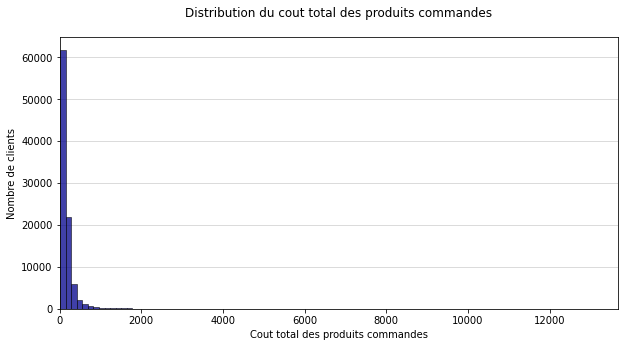

In [27]:
fig_data = data_cust[['price', 'freight_value']].sum(axis=1)

fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot(
    x=fig_data,
    color='darkblue',
    bins=100
)

ax.set_xlabel('Cout total des produits commandes')
ax.set_ylabel('Nombre de clients')
ax.set_title('Distribution du cout total des produits commandes',
             pad=20)

ax.set_xlim(left=0, right=fig_data.max())

ax.grid(visible=True, axis='y', color='lightgrey')
ax.set_axisbelow(True)

plt.show()

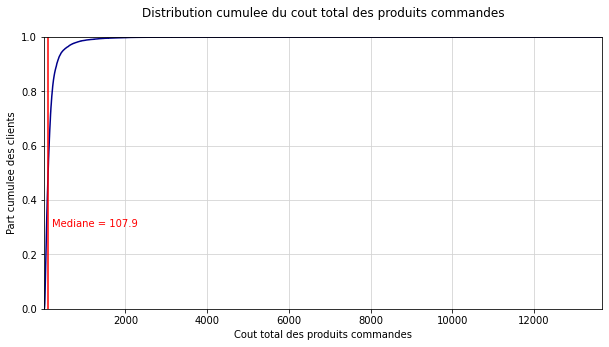

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.ecdfplot(
    x=fig_data,
    color='darkblue'
)

ax.set_xlabel('Cout total des produits commandes')
ax.set_ylabel('Part cumulee des clients')
ax.set_title('Distribution cumulee du cout total des produits commandes',
             pad=20)

median = fig_data.median()

ax.vlines(
    x=median,
    ymin=0,
    ymax=1,
    color='red'
)

ax.annotate(
    text=f"Mediane = {median:.1f}",
    xy=(median+100, 0.3),
    color='red'
)

ax.set_xlim(
    left=fig_data.min(),
    right=fig_data.max()
)

ax.grid(visible=True, color='lightgrey')
ax.set_axisbelow(True)

plt.show()

Nous visualisons également la distribution de la variable M(ontant), correspondant au coût annuel des produits commandés (hors frais de port).

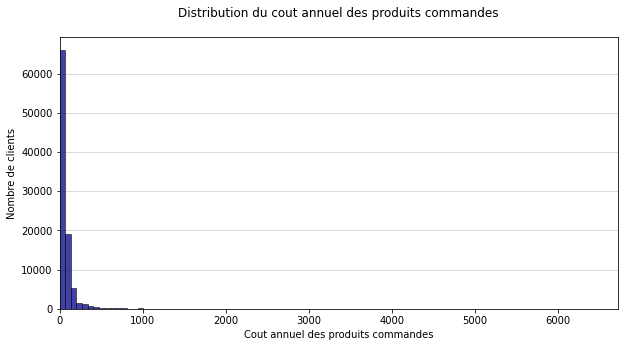

In [29]:
fig_data = data_cust['rfm_M']

fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot(
    x=fig_data,
    color='darkblue',
    bins=100
)

ax.set_xlabel('Cout annuel des produits commandes')
ax.set_ylabel('Nombre de clients')
ax.set_title('Distribution du cout annuel des produits commandes',
             pad=20)

ax.set_xlim(left=0, right=fig_data.max())

ax.grid(visible=True, axis='y', color='lightgrey')
ax.set_axisbelow(True)

plt.show()

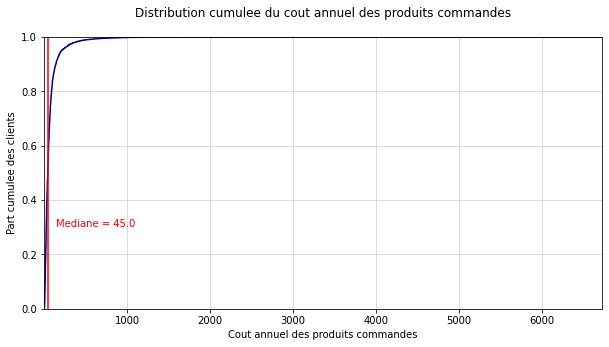

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.ecdfplot(
    x=fig_data,
    color='darkblue'
)

ax.set_xlabel('Cout annuel des produits commandes')
ax.set_ylabel('Part cumulee des clients')
ax.set_title('Distribution cumulee du cout annuel des produits commandes',
             pad=20)

median = fig_data.median()

ax.vlines(
    x=median,
    ymin=0,
    ymax=1,
    color='red'
)

ax.annotate(
    text=f"Mediane = {median:.1f}",
    xy=(median+100, 0.3),
    color='red'
)

ax.set_xlim(
    left=fig_data.min(),
    right=fig_data.max()
)

ax.grid(visible=True, color='lightgrey')
ax.set_axisbelow(True)

plt.show()

Nous remarquons une distribution concentrée près de l'origine, mais avec une forte dispersion des valeurs extrêmes. Afin d'améliorer la variance sur cette variable, nous introduisons une transformation logarithmique en log(1+x).

In [31]:
log_trans = FunctionTransformer(
    func=np.log1p,
    inverse_func=np.expm1,
    check_inverse=False
)

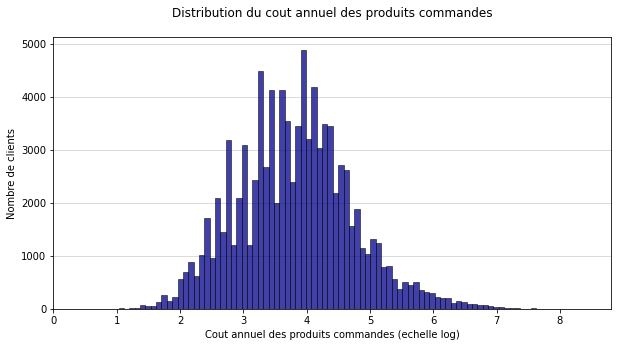

In [32]:
fig_data = log_trans.fit_transform(data_cust['rfm_M'])

fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot(
    x=fig_data,
    color='darkblue',
    bins=100
)

ax.set_xlabel('Cout annuel des produits commandes (echelle log)')
ax.set_ylabel('Nombre de clients')
ax.set_title('Distribution du cout annuel des produits commandes',
             pad=20)

ax.set_xlim(left=0, right=fig_data.max())

ax.grid(visible=True, axis='y', color='lightgrey')
ax.set_axisbelow(True)

plt.show()

### 3.2.3. Nombre de produits par client

Nous pouvons également observer la distribution du nombre de produits commandés par client.

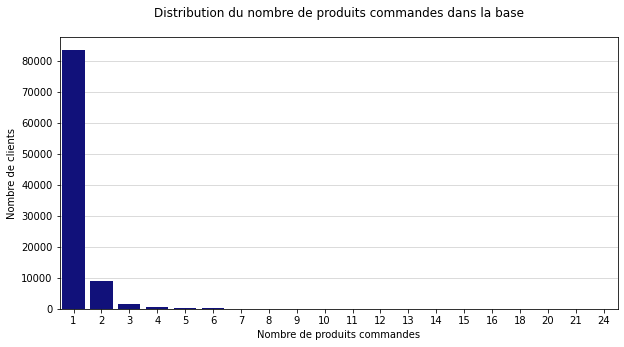

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.countplot(
    x=data_cust['order_item_id'].astype(int),
    color='darkblue'
)

ax.set_xlabel('Nombre de produits commandes')
ax.set_ylabel('Nombre de clients')
ax.set_title('Distribution du nombre de produits commandes dans la base',
             pad=20)

ax.grid(visible=True, axis='y', color='lightgrey')
ax.set_axisbelow(True)

plt.show()

In [34]:
pct_1_product =\
    data_cust['order_item_id'].value_counts()[1] / data_cust.shape[0]
display(
    Markdown(f"Au sein de notre base de donnees, seuls {1-pct_1_order:.0%} \
    des clients ont commande plus d'un produit sur la periode."))

Au sein de notre base de donnees, seuls 3%     des clients ont commande plus d'un produit sur la periode.

Cet élément rend hasardeuse toute tentative de dresser un profil client sur la base des types de produits commandés, ne disposant pour l'immense majorité des cas que d'une observation par client.

### 3.2.4. Période d'achats

Nous observons également la distribution des dépenses pendant et hors des périodes de fêtes identifiées.

In [35]:
# Creation d'une colonne par difference identifiant
# les montants de depenses hors fetes
data_cust['d_none'] = 1 - data_cust[day_cols].sum(axis=1)

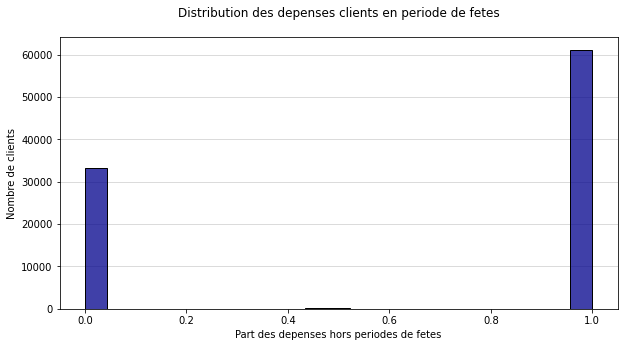

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot(
    x=data_cust['d_none'],
    color='darkblue'
)

ax.set_xlabel('Part des depenses hors periodes de fetes')
ax.set_ylabel('Nombre de clients')
ax.set_title('Distribution des depenses clients en periode de fetes', pad=20)

ax.grid(visible=True, color='lightgrey', axis='y')
ax.set_axisbelow(True)

plt.show()

Commme nous pouvions l'attendre compte tenu du nombre de clients ayant plusieurs commandes, nous voyons clairement deux modes : les clients ont dans leur quasi totalité exclusivement commandé durant des périodes de fêtes ou exclusivement hors périodes de fêtes.

Nous visualisons également la distribution de la variable R(écence), correspondant au coût annuel des produits commandés.

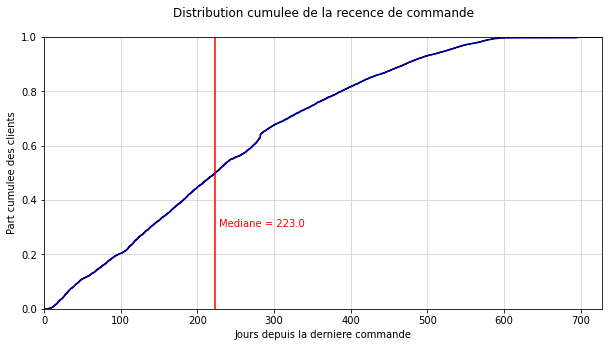

In [37]:
fig_data = data_cust['rfm_R']

fig, ax = plt.subplots(figsize=(10, 5))

sns.ecdfplot(
    x=fig_data,
    color='darkblue'
)

ax.set_xlabel('Jours depuis la derniere commande')
ax.set_ylabel('Part cumulee des clients')
ax.set_title('Distribution cumulee de la recence de commande', pad=20)

median = fig_data.median()

ax.vlines(
    x=median,
    ymin=0,
    ymax=1,
    color='red'
)

ax.annotate(
    text=f"Mediane = {median:.1f}",
    xy=(median+5, 0.3),
    color='red'
)

ax.set_xlim(
    left=0,
    right=fig_data.max()
)

ax.grid(visible=True, color='lightgrey')
ax.set_axisbelow(True)

plt.show()

### 3.2.5. Note moyenne par client

Nous observons maintenant la distribution des notes moyennes données par les clients, en moyenne.

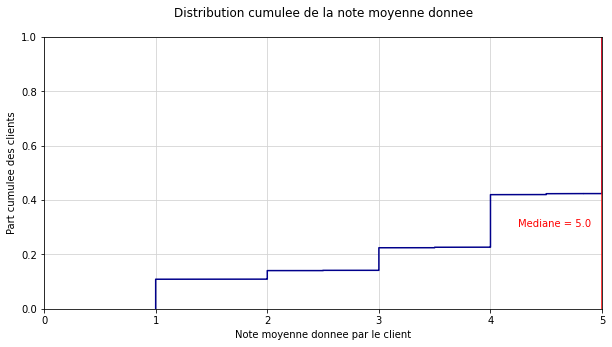

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.ecdfplot(
    x=data_cust['review_score_mean'],
    color='darkblue'
)

ax.set_xlabel('Note moyenne donnee par le client')
ax.set_ylabel('Part cumulee des clients')
ax.set_title('Distribution cumulee de la note moyenne donnee', pad=20)

median = data_cust['review_score_mean'].median()

ax.vlines(
    x=median,
    ymin=0,
    ymax=1,
    color='red'
)

ax.annotate(
    text=f"Mediane = {median:.1f}",
    xy=(median-0.75, 0.3),
    color='red'
)

ax.set_xlim(
    left=0,
    right=data_cust['review_score_mean'].max()
)

ax.grid(visible=True, color='lightgrey')
ax.set_axisbelow(True)

plt.savefig('figures/note_moyenne.png', bbox_inches='tight')

plt.show()

### 3.2.6. Distance moyenne de commmande

Nous concluons cette étape par l'observation de la distribution des distances moyennes séparant le client du vendeur.

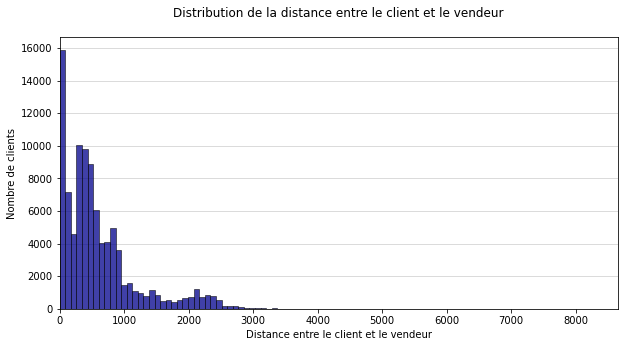

In [39]:
fig_data = data_cust['order_distance']

fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot(
    x=fig_data,
    color='darkblue',
    bins=100
)

ax.set_xlabel('Distance entre le client et le vendeur')
ax.set_ylabel('Nombre de clients')
ax.set_title(
    'Distribution de la distance entre le client et le vendeur',
    pad=20)

ax.set_xlim(left=0, right=fig_data.max())

ax.grid(visible=True, axis='y', color='lightgrey')
ax.set_axisbelow(True)

plt.show()

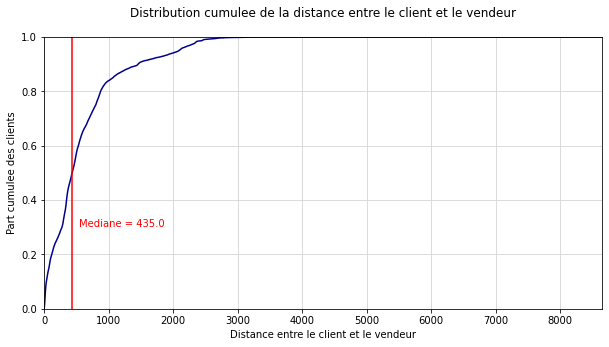

In [40]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.ecdfplot(
    x=data_cust['order_distance'],
    color='darkblue'
)

ax.set_xlabel('Distance entre le client et le vendeur')
ax.set_ylabel('Part cumulee des clients')
ax.set_title(
    'Distribution cumulee de la distance entre le client et le vendeur',
    pad=20)

median = data_cust['order_distance'].median()

ax.vlines(
    x=median,
    ymin=0,
    ymax=1,
    color='red'
)

ax.annotate(
    text=f"Mediane = {median:.1f}",
    xy=(median+100, 0.3),
    color='red'
)

ax.set_xlim(
    left=data_cust['order_distance'].min(),
    right=data_cust['order_distance'].max()
)

ax.grid(visible=True, color='lightgrey')
ax.set_axisbelow(True)

plt.show()

Nous remarquons que la plupart des consommateurs semblent faire appel à des vendeurs situés dans leur Etat. Cela s'explique probablement par une distribution géographique similaire entre les clients et les vendeurs, toutes deux naturellement concentrées sur les région à forte densité démographique.

Compte tenu de la distribution de nouveau concentrée sur les faibles valeurs, mais faisant apparaître des valeurs extrêmes comparativement très élevées, nous pouvons de nouveau appliquer une log-transformation à notre variable.

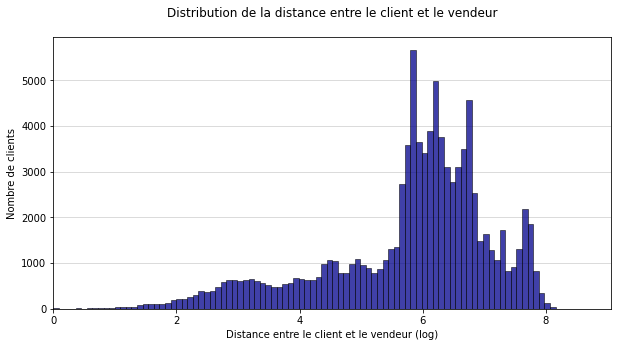

In [41]:
fig_data = log_trans.fit_transform(data_cust['order_distance'])

fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot(
    x=fig_data,
    color='darkblue',
    bins=100
)

ax.set_xlabel('Distance entre le client et le vendeur (log)')
ax.set_ylabel('Nombre de clients')
ax.set_title(
    'Distribution de la distance entre le client et le vendeur',
    pad=20)

ax.set_xlim(left=0, right=fig_data.max())

ax.grid(visible=True, axis='y', color='lightgrey')
ax.set_axisbelow(True)

plt.show()

# 4. Catégorisation

## 4.1. RFM avec K-means

Nous allons entraîner dans un premier temps un algorithme de K-means sur les trois variables RFM, en optimisant le nombre de clusters :
- Numériquement, sur la base de l'index de Calinski-Harabasz, qui mesure le rapport entre la variance intra-classe et la variance inter-classes observées
- Empiriquement, sur la base du besoin métier

In [42]:
rfm_cols = data_cust.columns[data_cust.columns.str.startswith('rfm_')]
pass_cols = rfm_cols[0:2]
log_cols = [rfm_cols[2]]

In [43]:
col_trans = ColumnTransformer(
    [('passthrough', 'passthrough', pass_cols),
     ('log_trans', log_trans, log_cols)],
    n_jobs=-1
)
rfm_kmeans = KMeans(random_state=1)
rfm_scaler = StandardScaler()

In [44]:
rfm_pipe = Pipeline([
    ('col_trans', col_trans),
    # Introduction d'un standard scaler pour que
    # les variables soient sur la meme echelle
    ('scaler', rfm_scaler),
    ('clustering', rfm_kmeans)
])

In [45]:
def params_score(X, model, **param_dict):

    """
    Fonction rendant le score de K-H d'un modele de clustering,
    entraine sur la base d'un jeu de parametres.

    Parametres :
    ------------
    - X : jeu de donnees a classifier et tester
    - model : modele format Pipeline de clustering,
    avec methodes .fit() et .predict()
    - param_dict : parametres applicables au modele model
    """

    assert isinstance(model, Pipeline),\
        "Le modele doit etre au format sklearn.pipeline.Pipeline"
    assert isinstance(model.steps[-2][1], StandardScaler),\
        "L'avant derniere etape doit etre un standard scaler"

    params_score = param_dict.copy()

    model.set_params(**param_dict)

    preds = model.fit(X).predict(X)

    # Preprocessing des donnees pour calcul variance
    preprocess = Pipeline(model.steps[:-1])
    X = preprocess.transform(X)

    if len(np.unique(preds)) > 1:
        params_score['score'] = calinski_harabasz_score(X,
                                                        preds)

    else:
        params_score['score'] = 0

    return params_score


def cluster_scores(model, X, params):

    '''
    Fonction iterant sur un ensemble de parametres un modele
    de classification unsupervised pour lequel les classes sont inconnues.
    Donne le score de Calinski Harabasz pour chaque combinaison de parametres.

    Parametres :
    ------------
    - model : modele format Pipeline de clustering unsupervised,
    avec methodes .fit() et .predict()
    - X : jeu de donnees
    - params : iterable contenant le nom et les valeurs des parametres a tester

    Resultat :
    ----------
    List de dict contenant chaque combinaison de parametres testee
    et le score en resultant.
    '''

    scores = []

    keys, values = zip(*params.items())
    params_iter =\
        [dict(zip(keys, value)) for value in itertools.product(*values)]

    scores =\
        [params_score(X=X, model=model,
                      **param_dict) for param_dict in params_iter]

    return scores

Nous visualisons également la distribution de la variable F(réquence), correspondant au coût annuel des produits commandés.

In [46]:
params = {'clustering__n_clusters': np.arange(2, 16, 1)}

In [47]:
scores = cluster_scores(rfm_pipe, data_cust[rfm_cols], params)

In [48]:
best_params = max(scores, key=lambda x: x['score']).copy()

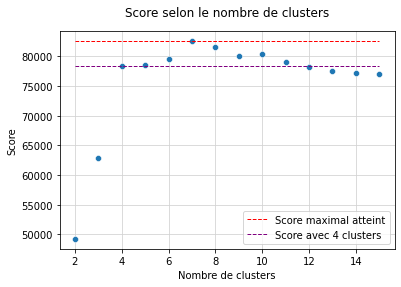

In [49]:
scores_df = pd.DataFrame(scores)

fig, ax = plt.subplots()

sns.scatterplot(
    data=scores_df,
    x='clustering__n_clusters',
    y='score'
)

ax.hlines(y=best_params['score'],
          linestyle='--',
          linewidth=1,
          xmin=scores_df['clustering__n_clusters'].min(),
          xmax=scores_df['clustering__n_clusters'].max(),
          color='red',
          label='Score maximal atteint')

ax.hlines(y=scores[2]['score'],
          linestyle='--',
          linewidth=1,
          xmin=scores_df['clustering__n_clusters'].min(),
          xmax=scores_df['clustering__n_clusters'].max(),
          color='purple',
          label='Score avec 4 clusters')

ax.legend(loc='lower right')

ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Score')
ax.set_title('Score selon le nombre de clusters', pad=15)

ax.grid(visible=True, color='lightgrey')

ax.set_axisbelow(True)

plt.show()

In [50]:
display(Markdown(
    f"Le meilleur score est obtenu avec \
    {best_params['clustering__n_clusters']:d} clusters."))

Le meilleur score est obtenu avec     7 clusters.

In [51]:
del best_params['score']
best_params

{'clustering__n_clusters': 7}

Nous allons étudier le résultat de cette catégorisation, en analysant les classes qui en résultent.

In [52]:
rfm_pipe.set_params(**best_params)
rfm_pipe.fit(data_cust[rfm_cols])

Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('passthrough', 'passthrough',
                                                  Index(['rfm_R', 'rfm_F'], dtype='object')),
                                                 ('log_trans',
                                                  FunctionTransformer(check_inverse=False,
                                                                      func=<ufunc 'log1p'>,
                                                                      inverse_func=<ufunc 'expm1'>),
                                                  ['rfm_M'])])),
                ('scaler', StandardScaler()),
                ('clustering', KMeans(n_clusters=7, random_state=1))])

In [53]:
rfm_class = rfm_pipe.predict(data_cust[rfm_cols])

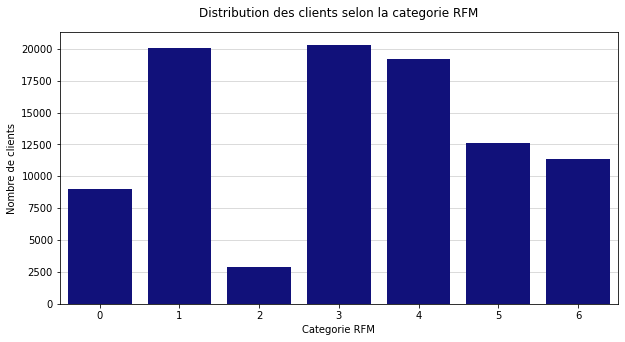

In [54]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.countplot(
    x=rfm_class,
    color='darkblue'
)

ax.set_ylabel('Nombre de clients')
ax.set_xlabel('Categorie RFM')
ax.set_title('Distribution des clients selon la categorie RFM', pad=15)

ax.grid(visible=True, axis='y', color='lightgrey')
ax.set_axisbelow(True)

plt.show()

Nous allons désormais analyser la composition des classes, en observant les coordonnées des centroïdes associés.

In [55]:
# Extraction des coordonnees des centroides
cluster_centers = rfm_pipe.named_steps['clustering'].cluster_centers_
# Creation d'une dataframe contenant ces donnees
cluster_data = pd.DataFrame(cluster_centers, columns=rfm_cols)
# Choix des couleurs pour les representations graphiques
palette = sns.color_palette(n_colors=len(cluster_centers))

In [56]:
def plot_centroid_coords(data, var_names=None, palette=None, figsize=(15, 10)):

    # Transformation des donnees en 3 colonnes :
    # index (classe), variable, et value (coordonnees)
    data = data.reset_index().melt(id_vars='index')

    fig, ax = plt.subplots(figsize=figsize)

    sns.lineplot(
        data=data,
        x='variable',
        y='value',
        hue='index',
        palette=palette)

    ax.grid(visible=True, axis='x', color='darkgrey')
    ax.grid(visible=True, axis='y', color='lightgrey')
    ax.set_axisbelow(True)

    ax.set_xlim(left=data['variable'][0], right=data['variable'][-1:])

    ax.set_xlabel('Variable')
    ax.set_ylabel('Coordonnee du centroide (standardisee)')
    ax.set_title('Visualisation des coordonnees des centroides')

    if var_names is not None:
        ax.set_xticks(data['variable'].unique(), var_names)

    ax.legend(title='Categorie')

    return fig

In [57]:
rfm_cols_names = [
    'Recence',
    'Frequence',
    'Montant'
]

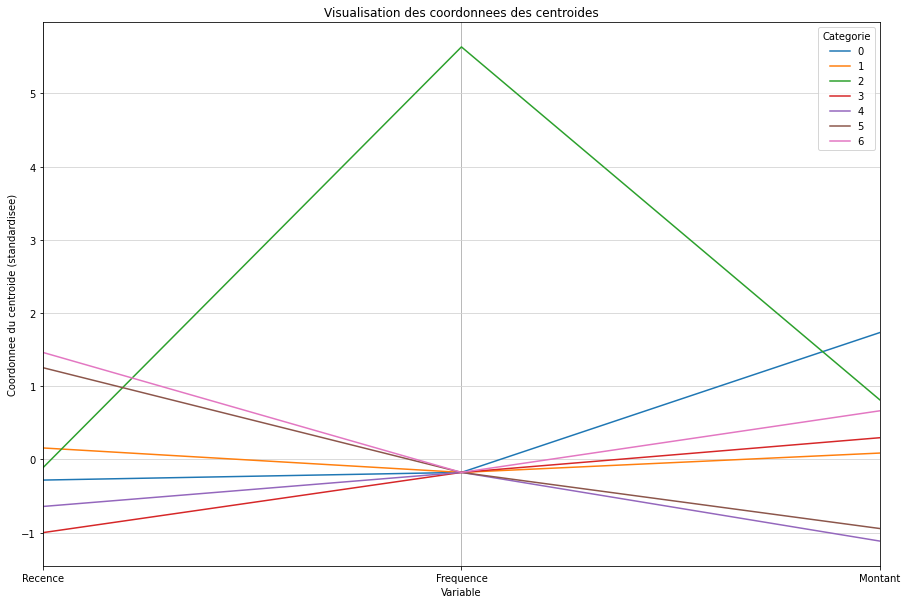

In [58]:
fig = plot_centroid_coords(cluster_data, rfm_cols_names, palette)

plt.show()

In [59]:
# Decompte du nombre de clients par cluster
cluster_count = np.unique(rfm_class, return_counts=True)[1]

In [60]:
# Creation de la colormap associee
cmap = ListedColormap(np.array(palette), N=len(cluster_centers))

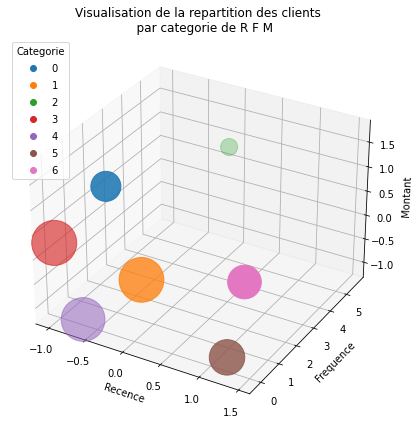

In [61]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    xs=cluster_data['rfm_R'],
    ys=cluster_data['rfm_F'],
    zs=cluster_data['rfm_M'],
    s=cluster_count/10,
    c=cluster_data.index,
    cmap=cmap
)

ax.legend(*scatter.legend_elements(), loc="upper left", title="Categorie")

ax.set_xlabel('Recence')
ax.set_ylabel('Frequence')
ax.set_zlabel('Montant')

ax.set_title('Visualisation de la repartition des clients\n\
    par categorie de R F M')

plt.show()

Nous pouvons voir que ces catégories sont complexes à analyser, représentant des degrés différents de récence et de montant de commandes, notamment.

Nous allons donc revoir notre approche, en réduisant le nombre de clusters. Graphiquement, nous voyons qu'à partir de 4 clusters, le score obtenu ne s'améliore que peu. Nous tentons donc de ne considérer que 4 clusters.

In [62]:
rfm_pipe.set_params(clustering__n_clusters=4)
rfm_pipe.fit(data_cust[rfm_cols])
rfm_class = rfm_pipe.predict(data_cust[rfm_cols])

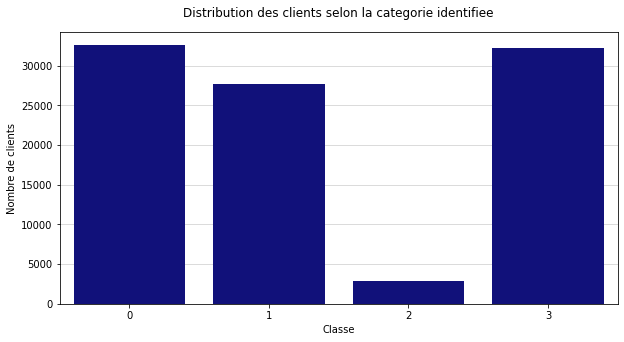

In [63]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.countplot(
    x=rfm_class,
    color='darkblue'
)

ax.set_ylabel('Nombre de clients')
ax.set_xlabel('Classe')
ax.set_title('Distribution des clients selon la categorie identifiee', pad=15)

ax.grid(visible=True, axis='y', color='lightgrey')
ax.set_axisbelow(True)

plt.show()

In [64]:
# Extraction des coordonnees des centroides
cluster_centers = rfm_pipe.named_steps['clustering'].cluster_centers_
# Creation d'une dataframe contenant ces donnees
cluster_data = pd.DataFrame(cluster_centers, columns=rfm_cols)
# Choix des couleurs pour les representations graphiques
palette = sns.color_palette(n_colors=len(cluster_centers))

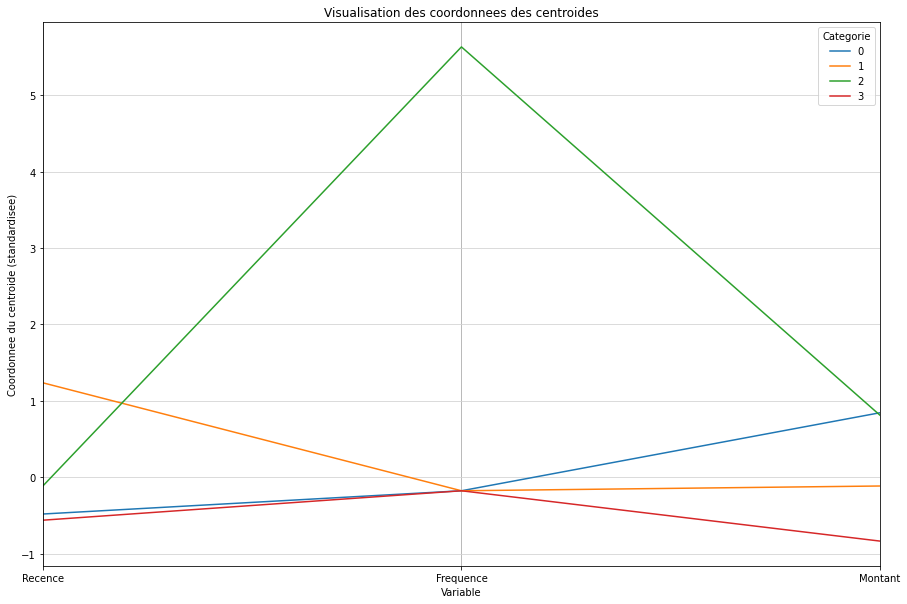

In [65]:
fig = plot_centroid_coords(cluster_data, rfm_cols_names, palette)

plt.savefig('figures/RFM_centroids.png', bbox_inches='tight')

plt.show()

In [66]:
# Decompte du nombre de clients par cluster
cluster_count = np.unique(rfm_class, return_counts=True)[1]

In [67]:
# Creation de la colormap associee
cmap = ListedColormap(np.array(palette), N=len(cluster_centers))

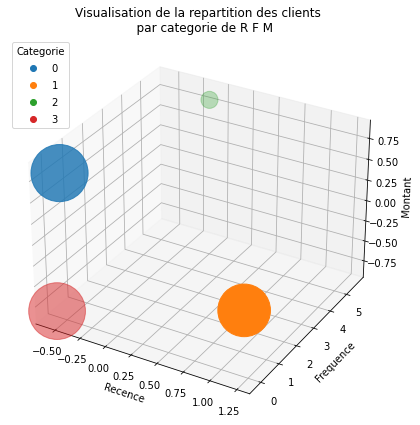

In [68]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    xs=cluster_data['rfm_R'],
    ys=cluster_data['rfm_F'],
    zs=cluster_data['rfm_M'],
    s=cluster_count/10,
    c=cluster_data.index,
    cmap=cmap
)

ax.legend(*scatter.legend_elements(), loc="upper left", title="Categorie")

ax.set_xlabel('Recence')
ax.set_ylabel('Frequence')
ax.set_zlabel('Montant')

ax.set_title('Visualisation de la repartition des clients\n\
    par categorie de R F M')

plt.show()

Nous obtenons désormais des clusters plus facilement compréhensibles : 
- catégorie 0 : clients récents, ayant commandé pour un montant élevé
- catégorie 1 : clients anciens
- catégorie 2 : clients fréquents
- catégorie 3 : clients récents, ayant commandé pour un montant faible

## 4.2. Inclusion d'autres indicateurs

Afin de tenter d'affiner cette première catégorisation, en particulier en ce qui concerne les clusters les plus importants, nous allons chercher à introduire d'autres variables à notre modèle. Nous proposons de considérer les variables suivantes :
- Score moyen laissé par le client, pour potentiellement identifier des clusters de clients insatisfaits
- Distance moyenne entre client et vendeur, pour potentiellement identifier un cluster de clients achetant très localement
- Part des achats réalisés durant des périodes de fêtes, pour identifier si certains clients n'utilisent le site que pour ces occasions

Dans l'idéal, nous pourrions également envisager d'ajouter une notion de catégorie de produits achetés par le client, afin d'affiner les groupes. Néanmoins, compte tenu du nombre très faible de clients ayant réalisé plus d'un achat dans notre base, combiné au nombre élevé de catégories de produits, cela reviendrait à ajouter plus de 70 dimensions à notre matrice, qui ne sont pas réductibles par ACP. Nous choisissons à ce stade de ne pas utiliser cette information, afin de ne pas complexifier l'analyse des classes.

In [69]:
# Identification des colonnes contenant les indicateurs additionels
added_cols = ['review_score_mean', 'd_none', 'order_distance']
added_cols_names = ['Score moyen',
                    'Part des commandes\nhors fetes',
                    'Distance de commande']

In [70]:
kmeans = KMeans(random_state=1)
scaler = StandardScaler()

Nous allons itérer sur ces variables pour trouver celles qui permettent d'affiner la base de manière actionable. Pour ce faire, nous allons utiliser un algorithme de K-means et visualiser les classes générées.

### 4.2.1. Notes laissées

Nous débutons par ajouter la note moyenne laissée par chaque client.

Pour rappel, cette variable contient des valeurs manquantes. Nous allons donc inclure une étape d'imputation à note pipeline, basée sur la médiane observée.

In [71]:
# Ajout a la liste des variables prises en compte
var_cols = rfm_cols.tolist() + [added_cols[0]]
var_cols_names = rfm_cols_names + [added_cols_names[0]]

imputed_cols = [added_cols[0]]
imputed_cols_names = [added_cols_names[0]]
passthrough_cols = [i for i in var_cols if i not in imputed_cols]
passthrough_cols_names =\
    [i for i in var_cols_names if i not in imputed_cols_names]
var_cols_names = passthrough_cols_names + imputed_cols_names

Nous revoyons également l'étape de log-transformation.

In [72]:
col_trans = ColumnTransformer(
    [('passthrough', 'passthrough', pass_cols),
     ('log_trans', log_trans, log_cols),
     ('imputer', SimpleImputer(strategy='median'), imputed_cols)],
    n_jobs=-1
)
rfm_kmeans = KMeans(random_state=1)
rfm_scaler = StandardScaler()

Nous pouvons désormais construire le pipeline de clustering.

In [73]:
kmeans_pipe = Pipeline([
    ('col_trans', col_trans),
    # Introduction d'un standard scaler pour que
    # les variables soient sur la meme echelle
    ('scaler', rfm_scaler),
    ('clustering', rfm_kmeans)
])

In [74]:
params = {'clustering__n_clusters': np.arange(2, 16, 1)}

In [75]:
scores = cluster_scores(kmeans_pipe, data_cust[var_cols], params)

In [76]:
best_params = max(scores, key=lambda x: x['score']).copy()

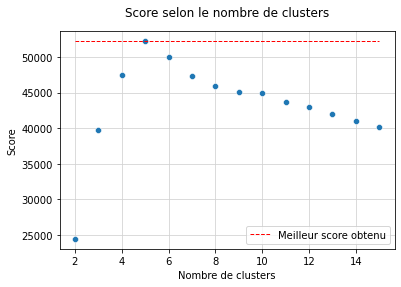

In [77]:
scores_df = pd.DataFrame(scores)

fig, ax = plt.subplots()

sns.scatterplot(
    data=scores_df,
    x='clustering__n_clusters',
    y='score')

ax.hlines(y=best_params['score'],
          linestyle='--',
          linewidth=1,
          xmin=scores_df['clustering__n_clusters'].min(),
          xmax=scores_df['clustering__n_clusters'].max(),
          color='red',
          label='Meilleur score obtenu')

ax.legend(loc='lower right')

ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Score')
ax.set_title('Score selon le nombre de clusters', pad=15)

ax.grid(visible=True, color='lightgrey')

ax.set_axisbelow(True)

plt.show()

In [78]:
display(Markdown(
    f"Le meilleur score est obtenu avec \
        {best_params['clustering__n_clusters']:d} clusters."))

Le meilleur score est obtenu avec         5 clusters.

In [79]:
del best_params['score']
best_params

{'clustering__n_clusters': 5}

Nous allons étudier le résultat de cette catégorisation, en analysant les classes qui en résultent.

In [80]:
kmeans_pipe.set_params(**best_params)
kmeans_pipe.fit(data_cust[var_cols])

Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('passthrough', 'passthrough',
                                                  Index(['rfm_R', 'rfm_F'], dtype='object')),
                                                 ('log_trans',
                                                  FunctionTransformer(check_inverse=False,
                                                                      func=<ufunc 'log1p'>,
                                                                      inverse_func=<ufunc 'expm1'>),
                                                  ['rfm_M']),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['review_score_mean'])])),
                ('scaler', StandardScaler()),
                ('clustering', KMeans(n_clusters=5, random_state=1))])

In [81]:
kmeans_class = kmeans_pipe.predict(data_cust[var_cols])

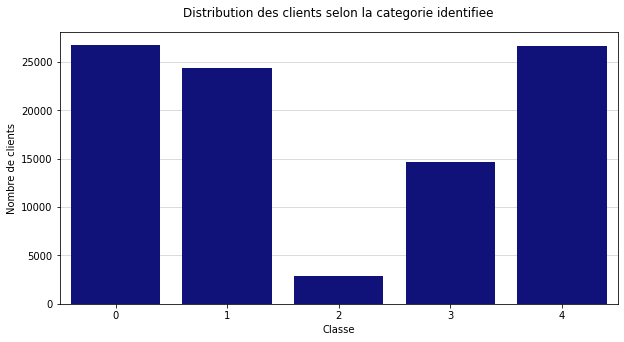

In [82]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.countplot(
    x=kmeans_class,
    color='darkblue'
)

ax.set_ylabel('Nombre de clients')
ax.set_xlabel('Classe')
ax.set_title('Distribution des clients selon la categorie identifiee', pad=15)

ax.grid(visible=True, axis='y', color='lightgrey')
ax.set_axisbelow(True)

plt.show()

In [83]:
# Extraction des coordonnees des centroides
cluster_centers = kmeans_pipe.named_steps['clustering'].cluster_centers_
# Creation d'une dataframe contenant ces donnees
cluster_data = pd.DataFrame(cluster_centers, columns=var_cols)
# Choix des couleurs pour les representations graphiques
palette = sns.color_palette(n_colors=len(cluster_centers))

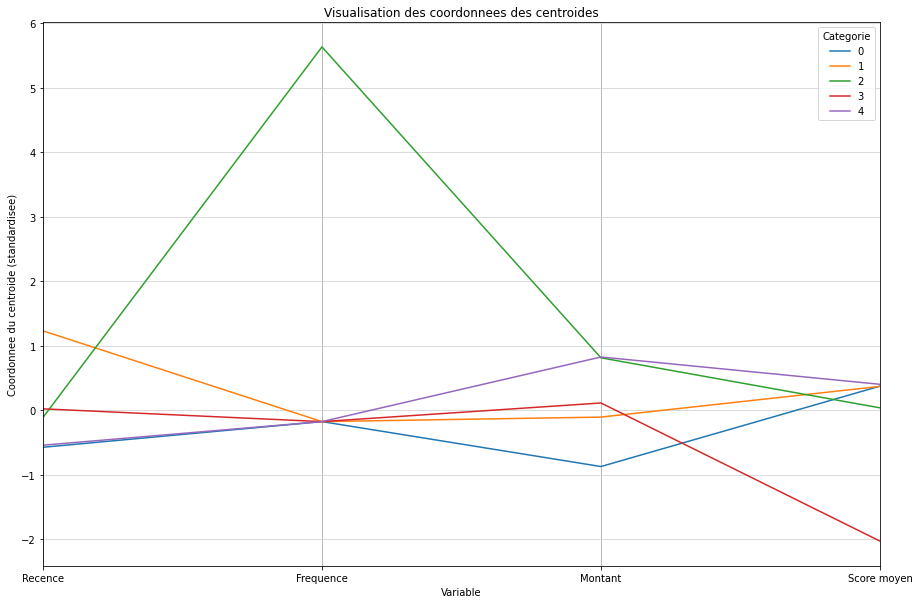

In [84]:
fig = plot_centroid_coords(cluster_data, var_cols_names, palette)

plt.savefig('figures/notes_centroids.png', bbox_inches='tight')

plt.show()

Les 5 catégories sont les suivantes : 
- Catégorie 0 : clients récents pour un montant faible
- Catégorie 1 : clients anciens
- Catégorie 2 : clients fréquents
- Catégorie 3 : clients insatisfaits de leur commande
- Catégorie 4 : clients récents pour un montant élevé

Nous retrouvons donc bien les catégories identifiées précédemment, qui est complétée d'une catégorie liée à l'insatisfaction, qui peut être utile à exploiter.

### 4.2.2. Période de commande

Nous ajoutons désormais l'information sur la période d'achat, au travers de l'indicateur créé précédemment indiquant la part des achats réalisés hors principales périodes de fêtes au Brésil.

In [85]:
# Ajout a la liste des variables prises en compte
var_cols = rfm_cols.tolist() + [added_cols[1]]
var_cols_names = rfm_cols_names + [added_cols_names[1]]

In [86]:
col_trans = ColumnTransformer(
    [('passthrough', 'passthrough', pass_cols),
     ('log_trans', log_trans, ['rfm_M']),
     ('passthrough2', 'passthrough', [added_cols[1]])],
    n_jobs=-1
)

In [87]:
kmeans_pipe = Pipeline([
    ('col_trans', col_trans),
    # Introduction d'un standard scaler pour que
    # les variables soient sur la meme echelle
    ('scaler', rfm_scaler),
    ('clustering', rfm_kmeans)
])

In [88]:
kmeans_pipe = Pipeline([
    ('col_trans', col_trans),
    ('scaler', scaler),
    ('clustering', kmeans)
])

In [89]:
scores = cluster_scores(kmeans_pipe, data_cust[var_cols], params)

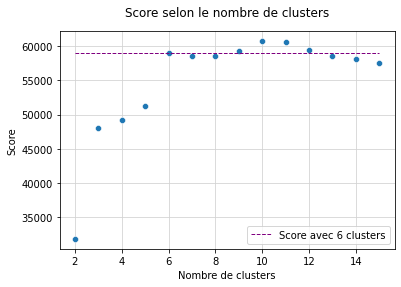

In [90]:
scores_df = pd.DataFrame(scores)
selected_params = scores[4]

fig, ax = plt.subplots()

sns.scatterplot(
    data=scores_df,
    x='clustering__n_clusters',
    y='score')

ax.hlines(y=selected_params['score'],
          linestyle='--',
          linewidth=1,
          xmin=scores_df['clustering__n_clusters'].min(),
          xmax=scores_df['clustering__n_clusters'].max(),
          color='purple',
          label='Score avec 6 clusters')

ax.legend(loc='lower right')

ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Score')
ax.set_title('Score selon le nombre de clusters', pad=15)

ax.grid(visible=True, color='lightgrey')

ax.set_axisbelow(True)

plt.show()

In [91]:
display(Markdown(
    f"Nous remarquons qu'a partir de\
        {selected_params['clustering__n_clusters']:d} clusters,\
        le score retenu se stabilise.\
        Nous considerons donc ce nombre de classes."))

Nous remarquons qu'a partir de        6 clusters,        le score retenu se stabilise.        Nous considerons donc ce nombre de classes.

In [92]:
del selected_params['score']
selected_params

{'clustering__n_clusters': 6}

Nous allons étudier le résultat de cette catégorisation, en analysant les classes qui en résultent.

In [93]:
kmeans_pipe.set_params(**selected_params)
kmeans_pipe.fit(data_cust[var_cols])

Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('passthrough', 'passthrough',
                                                  Index(['rfm_R', 'rfm_F'], dtype='object')),
                                                 ('log_trans',
                                                  FunctionTransformer(check_inverse=False,
                                                                      func=<ufunc 'log1p'>,
                                                                      inverse_func=<ufunc 'expm1'>),
                                                  ['rfm_M']),
                                                 ('passthrough2', 'passthrough',
                                                  ['d_none'])])),
                ('scaler', StandardScaler()),
                ('clustering', KMeans(n_clusters=6, random_state=1))])

In [94]:
kmeans_class = kmeans_pipe.predict(data_cust[var_cols])

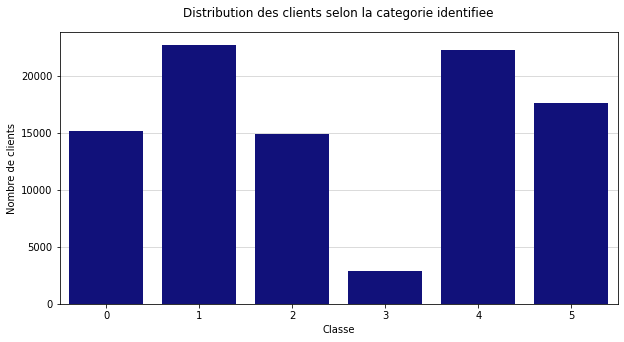

In [95]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.countplot(
    x=kmeans_class,
    color='darkblue'
)

ax.set_ylabel('Nombre de clients')
ax.set_xlabel('Classe')
ax.set_title('Distribution des clients selon la categorie identifiee', pad=15)

ax.grid(visible=True, axis='y', color='lightgrey')
ax.set_axisbelow(True)

plt.show()

In [96]:
# Extraction des coordonnees des centroides
cluster_centers = kmeans_pipe.named_steps['clustering'].cluster_centers_
# Creation d'une dataframe contenant ces donnees
cluster_data = pd.DataFrame(cluster_centers, columns=var_cols)
# Choix des couleurs pour les representations graphiques
palette = sns.color_palette(n_colors=len(cluster_centers))

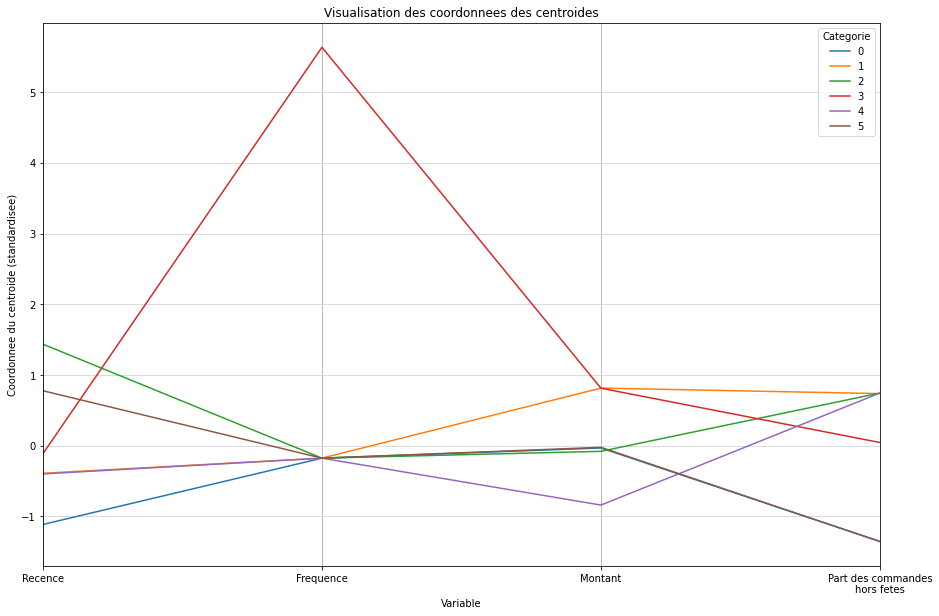

In [97]:
fig = plot_centroid_coords(cluster_data, var_cols_names, palette)

plt.savefig('figures/events_centroids.png', bbox_inches='tight')

plt.show()

Nous visualisons également les données sous forme numérique, afin de ne rien manquer.

In [98]:
cluster_data

,rfm_R,rfm_F,rfm_M,d_none
0,-1.115707,-0.177453,-0.033765,-1.356383
1,-0.390819,-0.177453,0.813861,0.735971
2,1.435113,-0.177453,-0.080713,0.744217
3,-0.113591,5.635300,0.812180,0.043900
4,-0.400879,-0.177453,-0.841160,0.744217
5,0.776447,-0.177453,-0.024295,-1.356383


Nous remarquons que l'ajout de cet indicateur rend plus complexe la classification. En effet, notamment du fait d'un nombre très restreint de clients ayant passé plus d'une commande, l'indicateur de commande hors période de fêtes est très majoritairement binaire : la seule commande a été effectué soit durant une période identifiée, soit hors de celles-ci.
Il est donc impossible de déterminer pour ces clients la tendance à l'achat durant ou hors fêtes, indépendemment de la date de dernier achat, et donc de la récence. Seuls les client ayant réalisé plus d'un achat peuvent être analysés au travers de ce prisme d'une manière convenable. Il serait intéressant de refaire l'exercise sur la base complète, mais nous ne prendrons pas en compte cette variable à ce stade. 

In [99]:
added_cols.remove(added_cols[1])
added_cols_names.remove(added_cols_names[1])

### 4.2.3. Distance de commande

Pour finir, nous intégrons la variable indiquant la distance moyenne séparant le client des vendeurs pour les produits achetés.

In [100]:
# Ajout a la liste des variables prises en compte
var_cols = rfm_cols.tolist() + [added_cols[1]]
var_cols_names = rfm_cols_names + [added_cols_names[1]]
log_cols += [added_cols[1]]

In [101]:
col_trans = ColumnTransformer(
    [('passthrough1', 'passthrough', pass_cols),
     ('log_trans', log_trans, log_cols)]
)

In [102]:
kmeans_pipe = Pipeline([
    ('col_trans', col_trans),
    # Introduction d'un standard scaler pour que
    # les variables soient sur la meme echelle
    ('scaler', rfm_scaler),
    ('clustering', rfm_kmeans)
])

In [103]:
scores = cluster_scores(kmeans_pipe, data_cust[var_cols], params)

In [104]:
best_params = max(scores, key=lambda x: x['score']).copy()

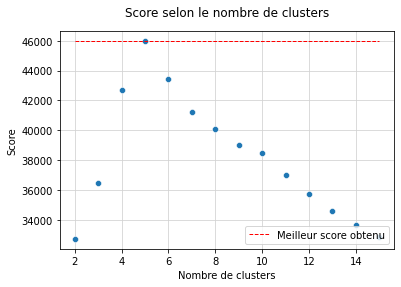

In [105]:
scores_df = pd.DataFrame(scores)

fig, ax = plt.subplots()

sns.scatterplot(
    data=scores_df,
    x='clustering__n_clusters',
    y='score')

ax.hlines(y=best_params['score'],
          linestyle='--',
          linewidth=1,
          xmin=scores_df['clustering__n_clusters'].min(),
          xmax=scores_df['clustering__n_clusters'].max(),
          color='red',
          label='Meilleur score obtenu')

ax.legend(loc='lower right')

ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Score')
ax.set_title('Score selon le nombre de clusters', pad=15)

ax.grid(visible=True, color='lightgrey')

ax.set_axisbelow(True)

plt.show()

In [106]:
display(Markdown(
    f"Le meilleur score est obtenu avec \
        {best_params['clustering__n_clusters']:d} clusters."))

Le meilleur score est obtenu avec         5 clusters.

In [107]:
del best_params['score']
best_params

{'clustering__n_clusters': 5}

Nous allons étudier le résultat de cette catégorisation, en analysant les classes qui en résultent.

In [108]:
kmeans_pipe.set_params(**best_params)
kmeans_pipe.fit(data_cust[var_cols])

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('passthrough1', 'passthrough',
                                                  Index(['rfm_R', 'rfm_F'], dtype='object')),
                                                 ('log_trans',
                                                  FunctionTransformer(check_inverse=False,
                                                                      func=<ufunc 'log1p'>,
                                                                      inverse_func=<ufunc 'expm1'>),
                                                  ['rfm_M',
                                                   'order_distance'])])),
                ('scaler', StandardScaler()),
                ('clustering', KMeans(n_clusters=5, random_state=1))])

In [109]:
kmeans_class = kmeans_pipe.predict(data_cust[var_cols])

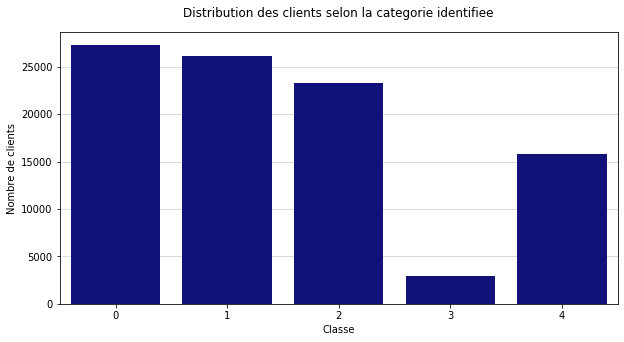

In [110]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.countplot(
    x=kmeans_class,
    color='darkblue'
)

ax.set_ylabel('Nombre de clients')
ax.set_xlabel('Classe')
ax.set_title('Distribution des clients selon la categorie identifiee', pad=15)

ax.grid(visible=True, axis='y', color='lightgrey')
ax.set_axisbelow(True)

plt.show()

In [111]:
# Extraction des coordonnees des centroides
cluster_centers = kmeans_pipe.named_steps['clustering'].cluster_centers_
# Creation d'une dataframe contenant ces donnees
cluster_data = pd.DataFrame(cluster_centers, columns=var_cols)
# Choix des couleurs pour les representations graphiques
palette = sns.color_palette(n_colors=len(cluster_centers))

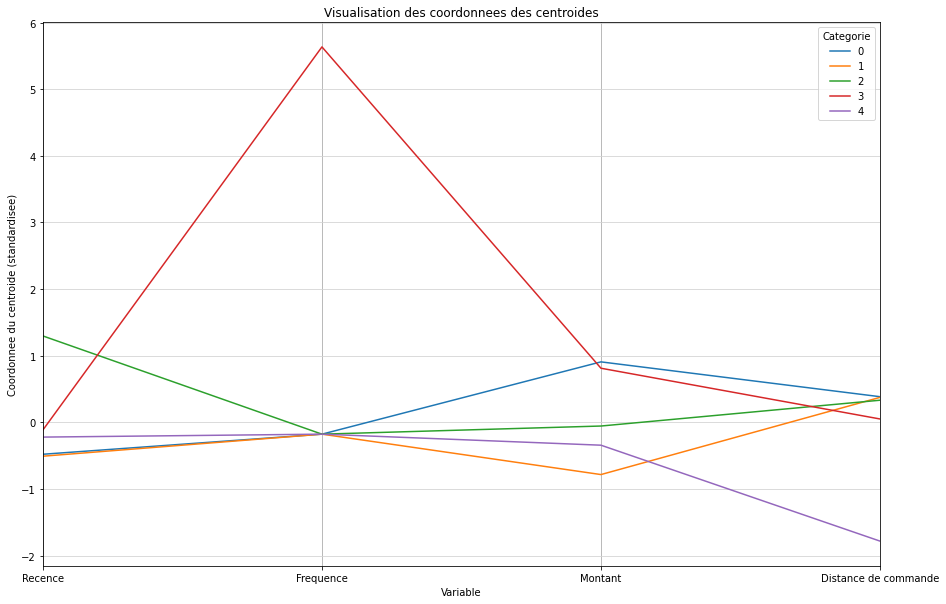

In [112]:
fig = plot_centroid_coords(cluster_data, var_cols_names, palette)

plt.savefig('figures/distance_centroids.png', bbox_inches='tight')

plt.show()

In [113]:
cluster_data

,rfm_R,rfm_F,rfm_M,order_distance
0,-0.478989,-0.177453,0.907665,0.384963
1,-0.508227,-0.177453,-0.783916,0.374550
2,1.296511,-0.177453,-0.055323,0.331902
3,-0.113591,5.635300,0.812180,0.050684
4,-0.221545,-0.177453,-0.343049,-1.782495


Cinq catégories sont identifiées :
- Catégorie 0 : clients récents, montant élevé
- Catégorie 1 : clients récents, montant faible
- Catégorie 2 : clients anciens
- Catégorie 3 : clients fréquents
- Catégorie 4 : clients proches géographiquement du vendeur

Ces informations peuvent être intéressantes pour une classification, et nous retenons donc cet indicateur.

Nous pouvons désormais consolider une liste globale des variables retenues.

In [114]:
# Ajout a la liste des variables prises en compte
var_cols = rfm_cols.tolist() + added_cols
var_cols_names = rfm_cols_names + added_cols_names

##  4.3. K-means

Nous entraînons désormais un algorithme de K-means en tenant compte de l'ensemble des indicateurs retenus.

In [115]:
imputed_cols_names = ['Score moyen']
passthrough_cols_names =\
    [i for i in var_cols_names if i not in imputed_cols_names]
var_cols_names = passthrough_cols_names + imputed_cols_names

In [116]:
col_trans = ColumnTransformer(
    [('passthrough', 'passthrough', pass_cols),
     ('log_trans', log_trans, log_cols),
     ('imputer', SimpleImputer(strategy='median'), imputed_cols)]
)

In [117]:
kmeans_pipe = Pipeline([
    ('col_trans', col_trans),
    # Introduction d'un standard scaler pour que
    # les variables soient sur la meme echelle
    ('scaler', rfm_scaler),
    ('clustering', rfm_kmeans)
])

In [118]:
params = {'clustering__n_clusters': np.arange(2, 16, 1)}

In [119]:
scores = cluster_scores(kmeans_pipe, data_cust[var_cols], params)

In [120]:
best_params = max(scores, key=lambda x: x['score']).copy()

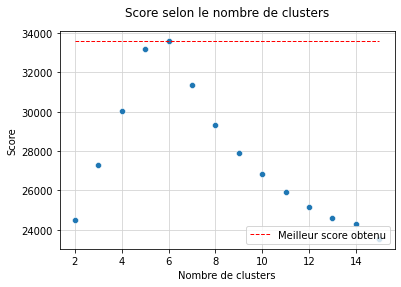

In [121]:
scores_df = pd.DataFrame(scores)

fig, ax = plt.subplots()

sns.scatterplot(
    data=scores_df,
    x='clustering__n_clusters',
    y='score')

ax.hlines(y=best_params['score'],
          linestyle='--',
          linewidth=1,
          xmin=scores_df['clustering__n_clusters'].min(),
          xmax=scores_df['clustering__n_clusters'].max(),
          color='red',
          label='Meilleur score obtenu')

ax.legend(loc='lower right')

ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Score')
ax.set_title('Score selon le nombre de clusters', pad=15)

ax.grid(visible=True, color='lightgrey')

ax.set_axisbelow(True)

plt.savefig('figures/KMeans_scores.png', bbox_inches='tight')

plt.show()

In [122]:
display(Markdown(
    f"Le meilleur score est obtenu avec\
        {best_params['clustering__n_clusters']:d} clusters."))

Le meilleur score est obtenu avec        6 clusters.

In [123]:
del best_params['score']
best_params

{'clustering__n_clusters': 6}

Nous allons étudier le résultat de cette catégorisation, en analysant les classes qui en résultent.

In [124]:
kmeans_pipe.set_params(**best_params)
kmeans_pipe.fit(data_cust[var_cols])

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  Index(['rfm_R', 'rfm_F'], dtype='object')),
                                                 ('log_trans',
                                                  FunctionTransformer(check_inverse=False,
                                                                      func=<ufunc 'log1p'>,
                                                                      inverse_func=<ufunc 'expm1'>),
                                                  ['rfm_M', 'order_distance']),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['review_score_mean'])])),
                ('scaler', StandardScaler()),
                ('clustering', KMeans(n_clusters=6, random_state=1))])

In [125]:
kmeans_class = kmeans_pipe.predict(data_cust[var_cols])

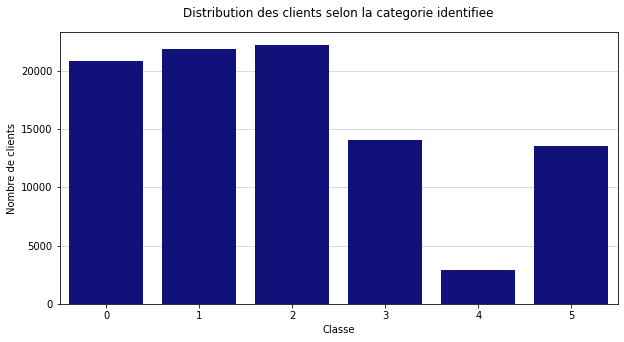

In [126]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.countplot(
    x=kmeans_class,
    color='darkblue'
)

ax.set_ylabel('Nombre de clients')
ax.set_xlabel('Classe')
ax.set_title('Distribution des clients selon la categorie identifiee', pad=15)

ax.grid(visible=True, axis='y', color='lightgrey')
ax.set_axisbelow(True)

plt.savefig('figures/kmeans_distr.png', bbox_inches='tight')

plt.show()

Les classes semblent être adéquatement réparties au sein de notre échantillon, compte tenu des variables prises en compte.

In [127]:
# Extraction des coordonnees des centroides
cluster_centers = kmeans_pipe.named_steps['clustering'].cluster_centers_
# Creation d'une dataframe contenant ces donnees
cluster_data = pd.DataFrame(cluster_centers, columns=var_cols)
# Choix des couleurs pour les representations graphiques
palette = sns.color_palette(n_colors=len(cluster_centers))

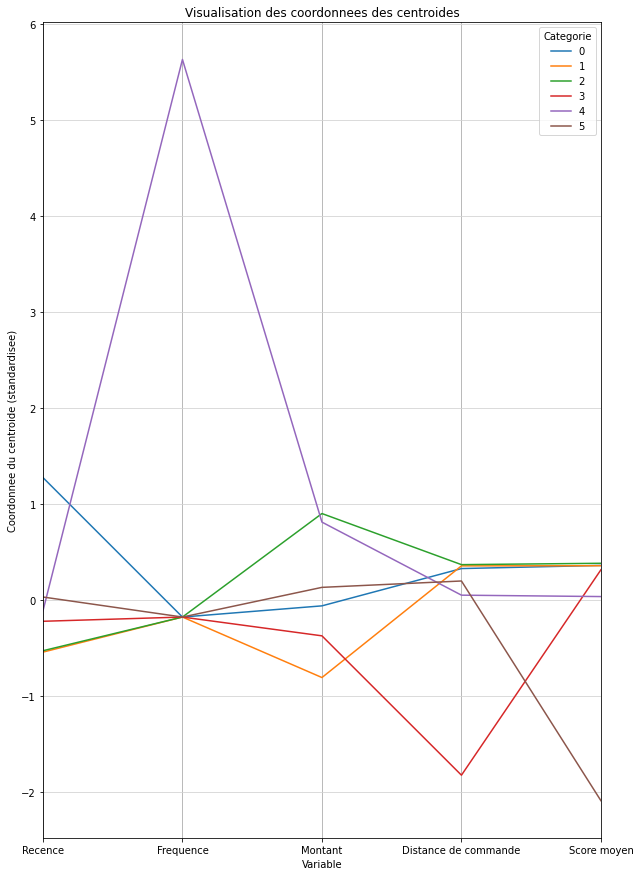

In [128]:
fig = plot_centroid_coords(cluster_data, var_cols_names, palette, (10, 15))

plt.savefig('figures/KMeans_centroids.png', bbox_inches='tight')

plt.show()

Nous pouvons observer les catégories suivantes :
- catégorie 0 : clients anciens
- catégorie 1 : clients récents, montant faible
- catégorie 2 : clients récents, montant élevé
- catégorie 3 : clients proches du vendeur
- catégorie 4 : clients fréquents
- catégorie 5 : clients insatisfaits

Ces catégories sont compréhensibles, et potentiellement utiles à des campagnes de communication ciblées, et les stratégies marketing associées. Nous considérons donc cette classification comme étant une base satisfaisante.

## 4.4. DBSCAN 

Nous allons étudier d'autres approches algorithmiques pour définir notre classification, en conservant les mêmes variables.

L'algorithme DBSCAN permet de ne pas pré-définir le nombre de clusters. Il repose cependant sur plusieurs paramètres spécifiques, en particulier : 
- $\epsilon$, la distance maximale séparant deux points au sein d'un même voisinage
- $n_{min}$, le nombre de points situés dans le voisinage des points intérieurs du cluster

Compte tenu de la taille significative de notre base de données, ainsi que de la présence de valeurs très dispersées sur nos variables, nous choisissons un $n_{min}$ élevé, que nous fixons à 100.

Concernant la valeur du $\epsilon$, nous allons l'approcher en étudiant la distance de chaque point à ses $n_{min}$ voisins.

In [129]:
n_min = 100

In [130]:
knn = NearestNeighbors(n_neighbors=n_min)

In [131]:
X = col_trans.fit_transform(data_cust[var_cols])
X = scaler.fit_transform(X)

In [132]:
max_distance = knn.fit(X).kneighbors(X)[0]
max_distance = [d[-1] for d in max_distance]
max_distance = np.sort(max_distance)

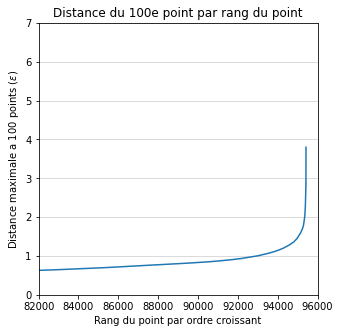

In [133]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.lineplot(
    x=np.arange(0, len(max_distance), 1),
    y=max_distance
)

ax.grid(visible=True, axis='y', color='lightgrey')
ax.set_axisbelow(True)

ax.set_ylabel(f"Distance maximale a {n_min} points ($\epsilon$)")
ax.set_xlabel("Rang du point par ordre croissant")
ax.set_title("Distance du 100e point par rang du point")

ax.set_xlim(left=82000, right=96000)
ax.set_ylim(bottom=0, top=7)

plt.savefig('figures/DBSCAN_eps.png', bbox_inches='tight')

plt.show()

En utilisant la méthode du coude, nous pouvons observer qu'à partir d'une distance d'environ 1.5, la curvature de la courbe change drastiquement. Nous proposons de retenir cette valeur pour $\epsilon$.

In [134]:
epsilon = 1.5

In [135]:
dbscan = DBSCAN(eps=epsilon, min_samples=n_min, n_jobs=-1)

In [136]:
dbscan_pipe = Pipeline([
    ('col_trans', col_trans),
    ('scaler', scaler),
    ('clustering', dbscan)
])

In [137]:
dbscan_class = dbscan_pipe.fit_predict(data_cust[var_cols])

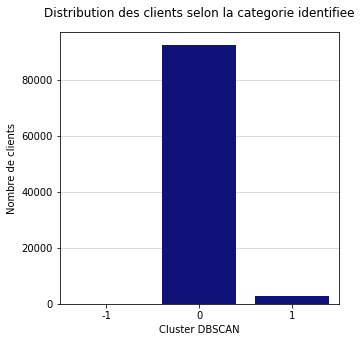

In [138]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.countplot(
    x=dbscan_class,
    color='darkblue'
)

ax.set_ylabel('Nombre de clients')
ax.set_xlabel('Cluster DBSCAN')
ax.set_title('Distribution des clients selon la categorie identifiee', pad=15)

ax.grid(visible=True, axis='y', color='lightgrey')
ax.set_axisbelow(True)

plt.savefig('figures/DBSCAN_distr.png', bbox_inches='tight')

plt.show()

Deux classes sont identifiées par l'algorithme tel que conçu, avec un nombre limité de données identifiées comme du bruit. Nous allons maintenant nous attacher à comprendre ce que ces classes représentent.

In [139]:
pairs = [pair for pair in itertools.combinations(var_cols, 2)]
pairs_names = [pair for pair in itertools.combinations(var_cols_names, 2)]

In [140]:
nrow, ncol = get_n_rowcol(pairs)

In [141]:
cmap = ListedColormap(np.array(palette), N=len(cluster_centers))

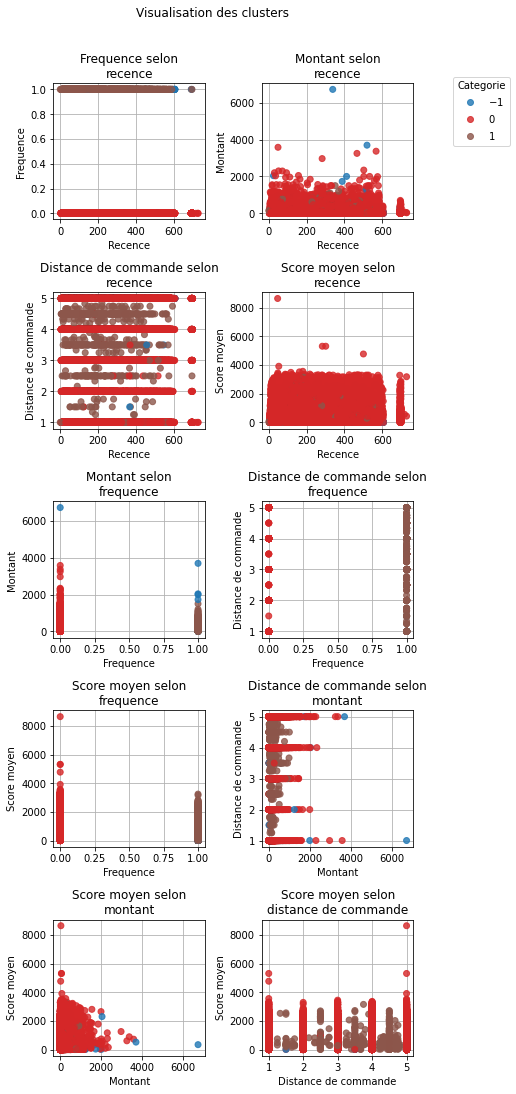

In [142]:
# Exclusion des quelques valeurs imputees
mapping = data_cust[var_cols].notna().all(axis=1)

fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*3, nrow*3))

for pair, name, ax in zip(pairs, pairs_names, fig.axes):
    scatter = ax.scatter(
        x=data_cust.loc[mapping, pair[0]],
        y=data_cust.loc[mapping, pair[1]],
        alpha=0.8,
        c=dbscan_class[mapping],
        cmap=cmap
    )

    ax.set_xlabel(name[0])
    ax.set_ylabel(name[1])
    ax.set_title(f"{name[1]} selon\n{name[0].lower()}")

    ax.grid(visible=True)
    ax.set_axisbelow(True)

fig.legend(*scatter.legend_elements(),
           title="Categorie",
           bbox_to_anchor=(1.2, .95))
fig.suptitle("Visualisation des clusters", y=1.01)

fig.tight_layout()

plt.show()

L'algorithme DBSCAN fonctionnant par densité, il est très utile pour identifier et définir des clusters distincts les uns des autres, quelle que soit leur forme. Dans notre cas, cependant, il est complexe de séparer notre donnée en clusters bien distincts. Par conséquent, nous pouvons voir que l'algorithme de DBSCAN s'est focalisé sur les variables discrètes pour définir des clusters, en particulier la variable de fréquence : 
- Catégorie 0 : clients n'ayant passé qu'une commande sur la période
- Catégorie 1 : clients ayant passé 2 commandes ou plus sur la période

Nous pouvons également observer que de nombreux clients sont considérés comme du bruit par l'algorithme, quand bien même ils peuvent être des clients intéressants d'un point de vue marketing : clients très fréquents, clients passant des commandes pour des montants élevés...

## 4.5. Clustering hiérarchique

Enfin, nous allons étudier une classification au travers d'un clustering hiérarchique ascendant.

Compte tenu de la taille de l'échantillon, nous allons procéder par étapes :
- Regroupement des données au sein d'un nombre moindre de clusters au travers d'un algorithme de K-means
- Application du clustering hiérarchique sur ces clusters

Nous débutons par choisir un nombre de clusters pour l'algorithme de K-means. Par principe, ce nombre doit être supérieur au nombre de clusters que nous souhaitons tester pour le clustering hiérarchique. Compte tenu des résultats précédents, nous choisissons de retenir au maximum 10 clusters au final, et allons donc procéder en conséquence.

In [143]:
hclust_kmeans = KMeans(random_state=5)

hclust_kmeans_pipe = Pipeline([
    ('col_trans', col_trans),
    ('scaler', scaler),
    ('clustering', hclust_kmeans)
])

In [144]:
# Nous testons un nombre de clusters entre 10 et 100, avec un pas de 10
params = {'clustering__n_clusters': np.linspace(10, 100, 10, dtype=int)}

In [145]:
scores = cluster_scores(hclust_kmeans_pipe, data_cust[var_cols], params)

In [146]:
best_params = max(scores, key=lambda x: x['score']).copy()

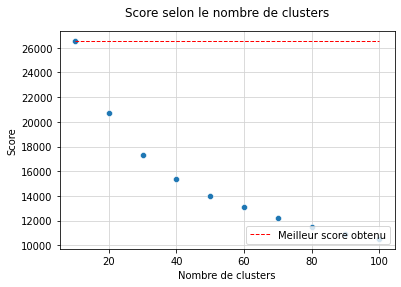

In [147]:
scores_df = pd.DataFrame(scores)

fig, ax = plt.subplots()

sns.scatterplot(
    data=scores_df,
    x='clustering__n_clusters',
    y='score')

ax.hlines(y=best_params['score'],
          linestyle='--',
          linewidth=1,
          xmin=scores_df['clustering__n_clusters'].min(),
          xmax=scores_df['clustering__n_clusters'].max(),
          color='red',
          label='Meilleur score obtenu')

ax.legend(loc='lower right')

ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Score')
ax.set_title('Score selon le nombre de clusters', pad=15)

ax.grid(visible=True, color='lightgrey')

ax.set_axisbelow(True)

plt.show()

In [148]:
display(Markdown(
    f"Le meilleur score est obtenu avec \
    {best_params['clustering__n_clusters']:d} clusters."))

Le meilleur score est obtenu avec     10 clusters.

La bibliothèque `sklearn` ne contenant pas de classe permettant d'utiliser cette approche directement, nous en créons une, fortement basée sur les outils déjà mis à notre disposition.

In [149]:
class CentroidAgglomerativeClustering(BaseEstimator, TransformerMixin):
    """
    Clustering hierarchique sur base d'un clustering K-means intermediaire.
    Concu pour traiter un volume de donnees eleve,
    cette combinaison de deux algorithmes procede par etapes :
    1. Clustering K-means et extraction des coordonnees des k centroides.
    2. Clustering hierarchique sur les k centroides.
    3. Application du resultat de l'etape 2. aux donnees
    selon leur classe apres l'etape 1.
    """
    def __init__(
            self,
            n_clusters=2,
            affinity='euclidean',
            memory=None,
            connectivity=None,
            compute_full_tree='auto',
            linkage='ward',
            distance_threshold=None,
            compute_distances=False,
            n_centroids=10,
            random_state=None):

        self.n_clusters = n_clusters
        self.affinity = affinity
        self.memory = memory
        self.connectivity = connectivity
        self.compute_full_tree = compute_full_tree
        self.linkage = linkage
        self.distance_threshold = distance_threshold
        self.compute_distances = compute_distances
        self.n_centroids = n_centroids
        self.random_state = random_state

    def fit(self, X, y=None):
        # Kmeans initial sur les donnees
        kmeans = KMeans(
            n_clusters=self.n_centroids,
            random_state=self.random_state)
        self.kmeans_ = kmeans.fit(X)

        # Clustering hierarchique sur les centroides
        self.agcl_ = AgglomerativeClustering(
            n_clusters=self.n_clusters,
            affinity=self.affinity,
            memory=self.memory,
            connectivity=self.connectivity,
            compute_full_tree=self.compute_full_tree,
            linkage=self.linkage,
            distance_threshold=self.distance_threshold,
            compute_distances=self.compute_distances)

        self.centroid_labels_ =\
            self.agcl_.fit_predict(self.kmeans_.cluster_centers_)

        return self

    def predict(self, X):
        # Prediction des centroides associes aux donnees
        self.kmeans_pred_ = self.kmeans_.predict(X)

        # Attribution du label associe apres clustering hierarchique
        pred_clusters = [self.centroid_labels_[i] for i in self.kmeans_pred_]
        self.labels_ = np.array(pred_clusters)

        return self.labels_

    def fit_predict(self, X, y=None):

        return self.fit(X).predict(X)

In [150]:
hclust = CentroidAgglomerativeClustering(
    n_centroids=best_params['clustering__n_clusters'],
    compute_distances=True,
    random_state=0
)

In [151]:
hclust_pipe = Pipeline([
    ('col_trans', col_trans),
    ('scaler', scaler),
    ('clustering', hclust)
])

In [152]:
params = {'clustering__n_clusters': np.arange(2, 11, 1)}

In [153]:
scores = cluster_scores(hclust_pipe, data_cust[var_cols], params=params)

In [154]:
best_params = max(scores, key=lambda x: x['score']).copy()

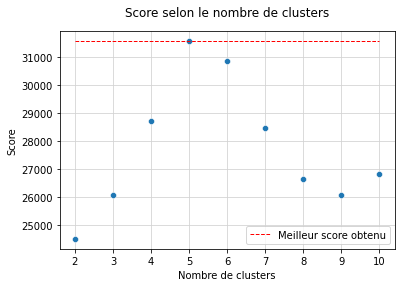

In [155]:
scores_df = pd.DataFrame(scores)
hclust_params = scores[6]

fig, ax = plt.subplots()

sns.scatterplot(
    data=scores_df,
    x='clustering__n_clusters',
    y='score')

ax.hlines(y=best_params['score'],
          linestyle='--',
          linewidth=1,
          xmin=scores_df['clustering__n_clusters'].min(),
          xmax=scores_df['clustering__n_clusters'].max(),
          color='red',
          label='Meilleur score obtenu')

ax.legend(loc='lower right')

ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Score')
ax.set_title('Score selon le nombre de clusters', pad=15)

ax.grid(visible=True, color='lightgrey')

ax.set_axisbelow(True)

plt.show()

In [156]:
display(Markdown(
    f"Le meilleur score est obtenu avec\
        {best_params['clustering__n_clusters']:d} clusters."))

Le meilleur score est obtenu avec        5 clusters.

In [157]:
del best_params['score']
best_params

{'clustering__n_clusters': 5}

Nous allons utiliser ce résultat pour définir le nombre de clusters.

In [158]:
hclust_pipe.set_params(**best_params)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  Index(['rfm_R', 'rfm_F'], dtype='object')),
                                                 ('log_trans',
                                                  FunctionTransformer(check_inverse=False,
                                                                      func=<ufunc 'log1p'>,
                                                                      inverse_func=<ufunc 'expm1'>),
                                                  ['rfm_M', 'order_distance']),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['review_score_mean'])])),
                ('scaler', StandardScaler()),
                ('clustering',
                 CentroidAgglomerativeClustering(compute_distances=True,
                                                 n_clusters=5,
                                                 random_state=0))])

In [159]:
hclust_class = hclust_pipe.fit_predict(data_cust[var_cols])

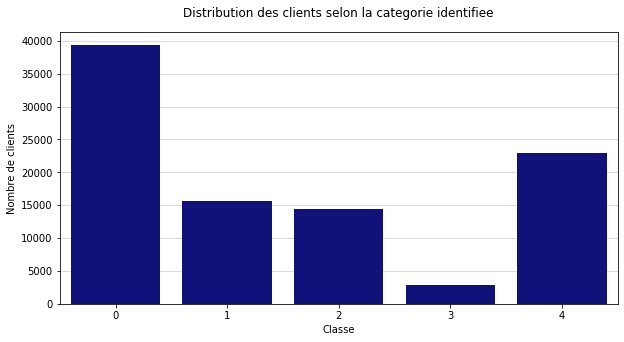

In [160]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.countplot(
    x=hclust_class,
    color='darkblue'
)

ax.set_ylabel('Nombre de clients')
ax.set_xlabel('Classe')
ax.set_title('Distribution des clients selon la categorie identifiee', pad=15)

ax.grid(visible=True, axis='y', color='lightgrey')
ax.set_axisbelow(True)

plt.show()

Nous observons immédiatement que les classes sont moins équilibrées que celles résultant du K-Means seul.

In [161]:
# Standardisation des donnees
scaled_data = hclust_pipe.named_steps['col_trans'].transform(data_cust[var_cols])
scaled_data = hclust_pipe.named_steps['scaler'].transform(scaled_data)
# Integration au sein d'un dataframe
scaled_data = pd.DataFrame(scaled_data, columns=var_cols)
# Calcul de la moyenne par cluster
cluster_data = scaled_data.groupby(hclust_class).mean()
# Choix des couleurs pour les representations graphiques
palette = sns.color_palette(n_colors=cluster_data.shape[0])

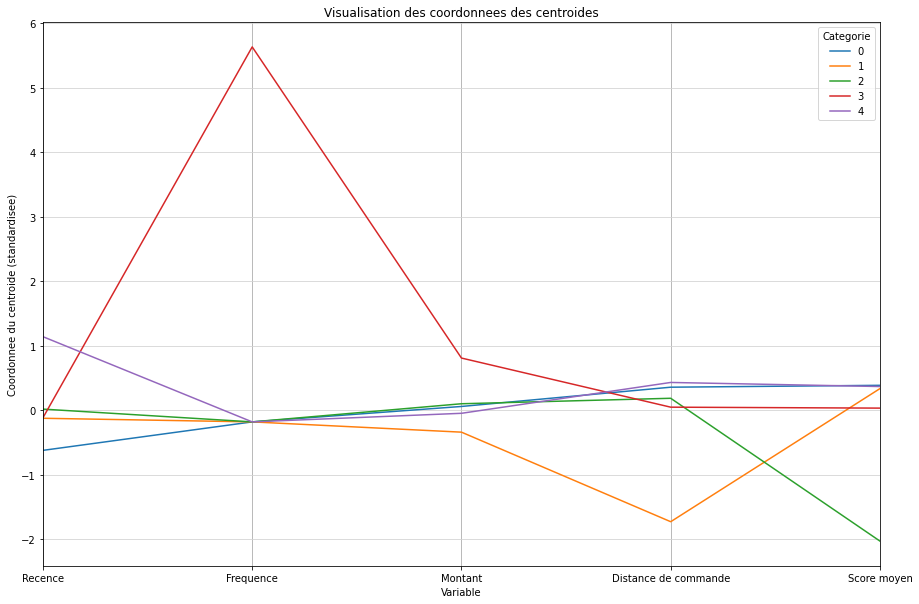

In [162]:
fig = plot_centroid_coords(cluster_data, var_cols_names, palette)

plt.savefig('figures/HClust_centroids.png', bbox_inches='tight')

plt.show()

Les classes résultantes sont proches de celles du K-Means :
- catégorie 0 : clients récents
- catégorie 1 : clients proches du vendeur
- catégorie 2 : clients insatisfaits
- catégorie 3 : clients fréquents
- catégorie 4 : clients anciens

Il nous manque cependant une information sur le montant de la commande, qui peut être utile pour distinguer certaines catégories de clients.

Nous visualisons également les clusters directement.

In [163]:
cmap = ListedColormap(np.array(palette), N=len(palette))

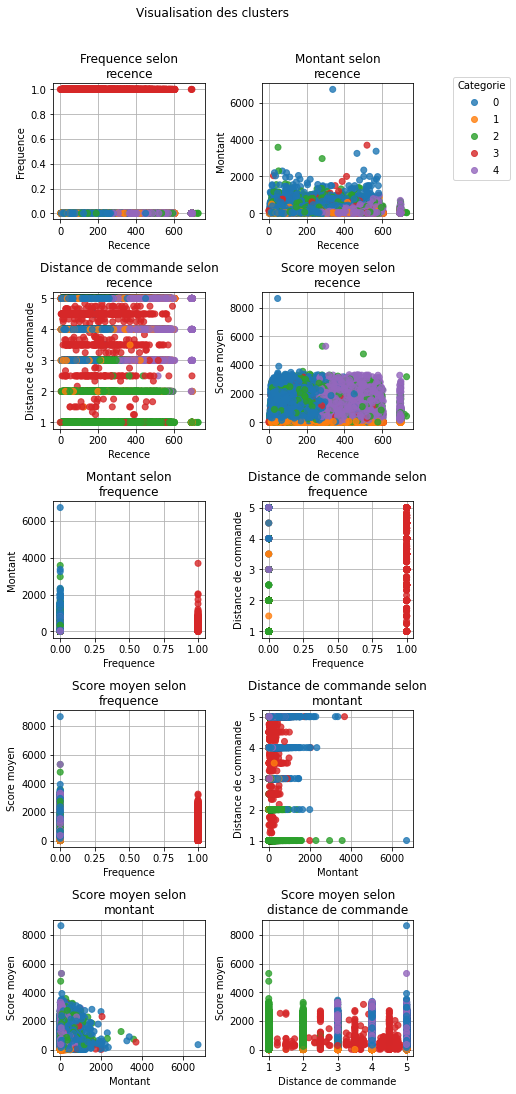

In [164]:
# Exclusion des quelques valeurs imputees
mapping = data_cust[var_cols].notna().all(axis=1)

fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*3, nrow*3))

for pair, name, ax in zip(pairs, pairs_names, fig.axes):
    scatter = ax.scatter(
        x=data_cust.loc[mapping, pair[0]],
        y=data_cust.loc[mapping, pair[1]],
        alpha=0.8,
        c=hclust_class[mapping],
        cmap=cmap
    )

    ax.set_xlabel(name[0])
    ax.set_ylabel(name[1])
    ax.set_title(f"{name[1]} selon\n{name[0].lower()}")

    ax.grid(visible=True)
    ax.set_axisbelow(True)

fig.legend(*scatter.legend_elements(),
           title="Categorie",
           bbox_to_anchor=(1.2, .95))
fig.suptitle("Visualisation des clusters", y=1.01)

fig.tight_layout()

plt.show()

In [165]:
def plot_dendrogram(model, **kwargs):
    # Affichage d'un dendrogramme a partir d'un AgglomerativeClustering
    # Source :
    # https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

    # Comptage du nombre d'elements par node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    fig = dendrogram(linkage_matrix, **kwargs)

    # Affichage du dendrogramme
    return fig

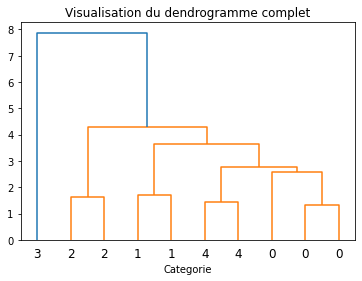

In [166]:
model = hclust_pipe.named_steps['clustering'].agcl_

fig = plot_dendrogram(
    model=model,
    leaf_label_func=lambda x: model.labels_[x]
)

ax = plt.gca()
ax.set_xlabel('Categorie')
ax.set_title('Visualisation du dendrogramme complet')

plt.savefig('figures/hclust_tree.png', bbox_inches='tight')

plt.show()

Il serait potentiellement possible de descendre dans l'abre pour créer une 6e catégorie, en séparant la catégorie 0 (clients récents) en deux. Néanmoins, la complexité de l'algorithme, nécessitant un K-Means préliminaire, pour obtenir des résultats équivalents, fait obstacle à son adoption pour notre problématique.

## 4.6. Choix du modèle

Pour répondre au besoin du client, notre modèle doit mettre en place un clustering simple à analyser et sur lequel des stratégies commerciales peuvent être conçues. Bien que techniquement intéressants, l'algorithme de DBSCAN ne produit pas des classes simples à manipuler. L'algorithme de clustering hiérarchique permet d'obtenir des classes au final proches de celles du K-Means, mais avec une complexité plus élevée de mise en oeuvre. Dans ce cas précis, ces deux derniers semblent moins adaptés que le clustering basé sur K-means.

Nous proposons donc de retenir ce dernier comme modèle.

En plus du score de Calinski-Harabasz, nous pouvons observer le score de silhouette de notre modèle, calculant le ratio entre les distances moyennes intra et inter clusters.

In [167]:
def silhouette_score_pipe(model, X, labels):
    """
    Fonction calculant le score de silhouette associe a un modele
    pour chaque element de X.

    Parametres :
    ------------
    - model : modele format Pipeline, contenant une etape au moins
    de preprocessing
    - X : elements pour lesquels calculer le score de silhouette
    - labels : labels associes a X, resultant de la prediction de model

    Resultat :
    ----------
    Iterable contenant le score de silhouette pour chaque element de X.
    """

    assert isinstance(model, Pipeline),\
        "Le modele doit etre au format sklearn.pipeline.Pipeline"

    preprocess = Pipeline(model.steps[:-1])
    X = preprocess.transform(X)
    return silhouette_samples(X, labels)

In [168]:
s_score_kmeans = silhouette_score_pipe(kmeans_pipe,
                                       data_cust[var_cols],
                                       kmeans_class)
s_score_rfm = silhouette_score_pipe(rfm_pipe,
                                    data_cust[rfm_cols],
                                    rfm_class)

In [169]:
display(Markdown(f"Le score de silhouette sur notre modele est de\
    {s_score_kmeans.mean():.3f}."))

Le score de silhouette sur notre modele est de    0.256.

Le score de silhouette, inférieur à 0.5, indique que les clusters restent en partie au moins proches les uns des autres; la classification, imparfaite, risque donc de perdre en stabilité avec le temps.

Nous visualisons également le score de silhouette obtenu par cluster.

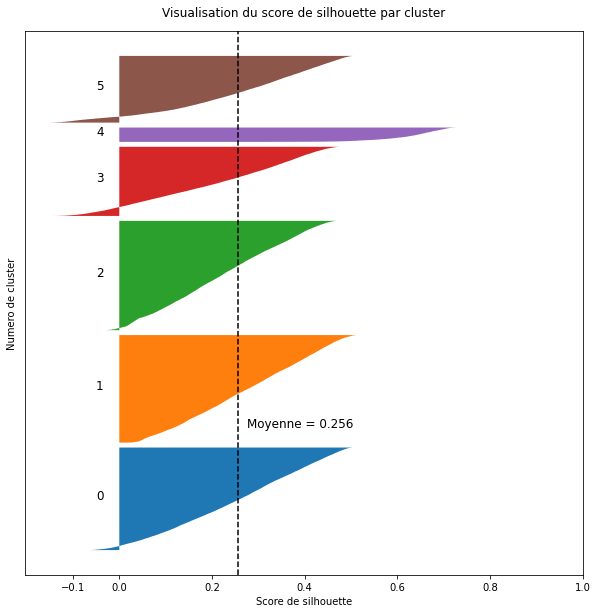

In [170]:
n_clusters = kmeans_pipe.get_params()['clustering__n_clusters']

fig, ax = plt.subplots(figsize=(10, 10))

y_lower = 0
for i in range(n_clusters):
    ith_cluster_silhouette_values = s_score_kmeans[kmeans_class == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
    )

    # Indication du numero de cluster
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i,
            str(i),
            fontsize=12)

    # Calcul du prochain seuil
    y_lower = y_upper + 1000

ax.set_title("Visualisation du score de silhouette par cluster",
             pad=15)
ax.set_xlabel("Score de silhouette")
ax.set_ylabel("Numero de cluster")

ax.axvline(x=s_score_kmeans.mean(), color="black", linestyle="--")
ax.text(x=s_score_kmeans.mean() + 0.02,
        y=25000,
        s=f'Moyenne = {s_score_kmeans.mean():.3f}',
        fontsize=12)

ax.set_yticks([])  # Clear the yaxis labels / ticks
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.savefig('figures/sil_score.png', bbox_inches='tight')

plt.show()

Nous enregistrons le modèle final retenu.

In [171]:
joblib.dump(kmeans_pipe, 'model/kmeans.joblib')
# Enregistrement des variables et de leur intitule
with open('model/var_cols.csv',
          'w',
          newline='') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',')
    csvwriter.writerow(var_cols)
with open('model/var_cols_names.csv',
          'w',
          newline='',
          encoding="utf-8") as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',')
    csvwriter.writerow(var_cols_names)